#### Image Classification

In [1]:
'''Problem Statement: The goal of the project is to classify images of fruits and vegetables into their respective categories accurately 
                       using a CNN model developed in TensorFlow.
                       The dataset contains a diverse range of fruits and vegetables images, making it challenging to classify them accurately. 
                       
                       #Motivation behind selecting the PS
                       The project is motivated by increasing availability of large image datasets and the rise of deep 
                       learning techniques, there is a growing need to develop accurate and efficient image classification systems. 
                       Classifying images has numerous real-world applications, In the case of the given dataset, accurate image 
                       classification of fruits and vegetables can help in food production, agriculture, and nutrition-related industries.
                       Manual sorting of fruits and vegetables in a warehouse or grocery store is a tedious and challenging task. 
                       An image classification system can automate this process, saving time and reducing errors.                 


    Dataset: Fruits and Vegetables Image Recognition Dataset
    link: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
    Description: This dataset contains images of the following food items:
    fruits- banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
    vegetables- cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage,lettuce,
                spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato,  
                paprika, jalepeno, ginger, garlic, peas, eggplant.
                
    ref: https://github.com/priteshkeleven/Food101/blob/master/transfer_learning_food101.ipynb'''

'Problem Statement: The goal of the project is to classify images of fruits and vegetables into their respective categories accurately \n                       using a CNN model developed in TensorFlow.\n                       The dataset contains a diverse range of fruits and vegetables images, making it challenging to classify them accurately. \n                       \n                       #Motivation behind selecting the PS\n                       The project is motivated by increasing availability of large image datasets and the rise of deep \n                       learning techniques, there is a growing need to develop accurate and efficient image classification systems. \n                       Classifying images has numerous real-world applications, In the case of the given dataset, accurate image \n                       classification of fruits and vegetables can help in food production, agriculture, and nutrition-related industries.\n                       Manual sorting 

In [2]:
!pip install tensorflow==2.9.1

In [3]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

fruit-and-vegetable-image-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import tensorflow as tf
import zipfile
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

2023-04-06 13:46:31.234773: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import datetime

In [6]:
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instance to store log files.
    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"
    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [7]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img / 255.
    else:
        return img

In [8]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.
    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.
    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).
    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.
    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] 
    n_classes = cm.shape[0]  

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  
           yticks=np.arange(n_classes),
           xticklabels=labels, 
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [9]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: 
        pred_class = class_names[pred.argmax()] 
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] 

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [10]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [11]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
             plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
             plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [12]:
def unzip_data(filename):
    """
    Unzips filename into the current working directory.
    Args:
      filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

In [13]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
      dir_path (str): target directory
    Returns:
      A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [14]:
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results


In [15]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [16]:
unzip_data("fruit-and-vegetable-image-recognition.zip")

In [17]:
train_dir = "train"
test_dir = "test"
validation_dir = "validation"

In [18]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               image_size=IMG_SIZE,
                                                                               label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False)

Found 3115 files belonging to 36 classes.
Found 359 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


2023-04-06 13:46:50.151004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-06 13:46:50.221347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-06 13:46:50.221391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-06 13:46:50.222487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

In [19]:
checkpoint_path = "checkpoint/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [20]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.Rescaling(1/255.) # Rescale images required for ResNet50v2
], name="data_augmentation")

## EfficientNetB0

In [21]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b0 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_b0.trainable = False

# Setup model architecture with trainable top layres
inputs_b0 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b0) 
x = base_model_b0(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b0 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b0 = tf.keras.Model(inputs_b0, outputs_b0)

In [22]:
# Compile the model
model_b0.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [23]:
model_b0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                46116     
                                                                 
Total params: 4,095,687
Trainable params: 46,116
Non-trainabl

In [24]:
base_model_history_b0 = model_b0.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b0")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b0/20230406-134653
Epoch 1/5


2023-04-06 13:46:56.472136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:46:56.566906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:46:56.786018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:46:57.770786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:46:57.927699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:46:59.536935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


 1/98 [..............................] - ETA: 13:50 - loss: 3.7045 - accuracy: 0.0312

2023-04-06 13:47:01.563013: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 5/98 [>.............................] - ETA: 33s - loss: 3.6046 - accuracy: 0.0250

2023-04-06 13:47:03.037327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 35s - loss: 3.5105 - accuracy: 0.0664

2023-04-06 13:47:04.435648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:04.572616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 33s - loss: 3.3998 - accuracy: 0.1224

2023-04-06 13:47:05.964496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 32s - loss: 3.3194 - accuracy: 0.1540

2023-04-06 13:47:06.650332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 30s - loss: 3.2474 - accuracy: 0.1746

2023-04-06 13:47:07.675717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 24s - loss: 2.9713 - accuracy: 0.2705

2023-04-06 13:47:11.653565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 23s - loss: 2.9282 - accuracy: 0.2863

2023-04-06 13:47:12.172319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 21s - loss: 2.8373 - accuracy: 0.3205

2023-04-06 13:47:13.081825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 16s - loss: 2.6041 - accuracy: 0.3883

2023-04-06 13:47:16.056713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 15s - loss: 2.5676 - accuracy: 0.4011

2023-04-06 13:47:16.750624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:16.753170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


54/98 [===============>..............] - ETA: 13s - loss: 2.4877 - accuracy: 0.4248

2023-04-06 13:47:18.419352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:18.472268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 12s - loss: 2.4313 - accuracy: 0.4391

2023-04-06 13:47:19.205652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:19.210825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 11s - loss: 2.3882 - accuracy: 0.4529

2023-04-06 13:47:20.108921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 11s - loss: 2.3731 - accuracy: 0.4577

2023-04-06 13:47:20.427216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 38s 302ms/step - loss: 1.9729 - accuracy: 0.5483 - val_loss: 1.2669 - val_accuracy: 0.6250
Epoch 2/5


2023-04-06 13:47:31.082715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:31.192652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:31.391936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:32.403435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:32.570648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 23s - loss: 1.1071 - accuracy: 0.7437

2023-04-06 13:47:33.848282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 21s - loss: 1.0780 - accuracy: 0.7500

2023-04-06 13:47:34.583850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:34.730211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 21s - loss: 1.0426 - accuracy: 0.7630

2023-04-06 13:47:35.452387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 21s - loss: 1.0337 - accuracy: 0.7716

2023-04-06 13:47:35.956230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 21s - loss: 1.0065 - accuracy: 0.7793

2023-04-06 13:47:36.801613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 16s - loss: 1.0411 - accuracy: 0.7619

2023-04-06 13:47:39.470902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 16s - loss: 1.0388 - accuracy: 0.7604

2023-04-06 13:47:39.736786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 14s - loss: 1.0234 - accuracy: 0.7693

2023-04-06 13:47:40.422376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 12s - loss: 0.9720 - accuracy: 0.7759

2023-04-06 13:47:43.658855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 11s - loss: 0.9745 - accuracy: 0.7742

2023-04-06 13:47:44.193602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:44.194286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


54/98 [===============>..............] - ETA: 10s - loss: 0.9595 - accuracy: 0.7766

2023-04-06 13:47:45.553549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:45.588661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 9s - loss: 0.9535 - accuracy: 0.7775

2023-04-06 13:47:46.223576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:46.224645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 8s - loss: 0.9456 - accuracy: 0.7767

2023-04-06 13:47:47.046492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 8s - loss: 0.9421 - accuracy: 0.7768

2023-04-06 13:47:47.333393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 25s 237ms/step - loss: 0.8879 - accuracy: 0.7884 - val_loss: 0.7704 - val_accuracy: 0.8438
Epoch 3/5


2023-04-06 13:47:55.930442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:56.035839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:56.274046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:57.356100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:57.549073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 23s - loss: 0.7109 - accuracy: 0.8188

2023-04-06 13:47:58.663364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 22s - loss: 0.7172 - accuracy: 0.8242

2023-04-06 13:47:59.573329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:47:59.733655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 22s - loss: 0.7130 - accuracy: 0.8203

2023-04-06 13:48:00.505924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 21s - loss: 0.7236 - accuracy: 0.8149

2023-04-06 13:48:00.806766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 19s - loss: 0.7122 - accuracy: 0.8184

2023-04-06 13:48:01.340697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 15s - loss: 0.7213 - accuracy: 0.8214

2023-04-06 13:48:03.844436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 15s - loss: 0.7185 - accuracy: 0.8188

2023-04-06 13:48:04.109408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 13s - loss: 0.7235 - accuracy: 0.8162

2023-04-06 13:48:04.760446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 10s - loss: 0.7150 - accuracy: 0.8145

2023-04-06 13:48:07.350059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 10s - loss: 0.7139 - accuracy: 0.8125

2023-04-06 13:48:07.805239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:07.806576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.7076 - accuracy: 0.8148

2023-04-06 13:48:08.781992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:08.813374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 8s - loss: 0.7067 - accuracy: 0.8152

2023-04-06 13:48:09.391884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:09.392739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 7s - loss: 0.6995 - accuracy: 0.8150

2023-04-06 13:48:10.204611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.8169

2023-04-06 13:48:10.500800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 21s 200ms/step - loss: 0.6603 - accuracy: 0.8273 - val_loss: 0.5926 - val_accuracy: 0.8438
Epoch 4/5


2023-04-06 13:48:17.235652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:17.319912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:17.515239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:18.498397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:18.662260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 16s - loss: 0.6384 - accuracy: 0.8062

2023-04-06 13:48:19.502512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 15s - loss: 0.5882 - accuracy: 0.8229

2023-04-06 13:48:20.218672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:20.376764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 18s - loss: 0.5830 - accuracy: 0.8203

2023-04-06 13:48:21.080578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 17s - loss: 0.5733 - accuracy: 0.8281

2023-04-06 13:48:21.388655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 16s - loss: 0.5644 - accuracy: 0.8364

2023-04-06 13:48:21.980668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/98 [=======>......................] - ETA: 15s - loss: 0.5881 - accuracy: 0.8356

2023-04-06 13:48:24.466260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 14s - loss: 0.5853 - accuracy: 0.8365

2023-04-06 13:48:24.828430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 13s - loss: 0.5819 - accuracy: 0.8409

2023-04-06 13:48:25.488768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 10s - loss: 0.5737 - accuracy: 0.8464

2023-04-06 13:48:28.011084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 9s - loss: 0.5718 - accuracy: 0.8463 

2023-04-06 13:48:28.555390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:28.556717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


54/98 [===============>..............] - ETA: 8s - loss: 0.5705 - accuracy: 0.8449

2023-04-06 13:48:29.686061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:29.719132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 8s - loss: 0.5718 - accuracy: 0.8432

2023-04-06 13:48:30.379551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:30.380200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 7s - loss: 0.5681 - accuracy: 0.8438

2023-04-06 13:48:31.081449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 7s - loss: 0.5668 - accuracy: 0.8433

2023-04-06 13:48:31.363988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 22s 207ms/step - loss: 0.5492 - accuracy: 0.8478 - val_loss: 0.4836 - val_accuracy: 0.8750
Epoch 5/5


2023-04-06 13:48:38.979381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:39.068805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:39.281510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:40.255383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:40.411718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 16s - loss: 0.3738 - accuracy: 0.9219

2023-04-06 13:48:41.508920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 15s - loss: 0.3933 - accuracy: 0.9141

2023-04-06 13:48:41.893619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:42.043435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 16s - loss: 0.4448 - accuracy: 0.8880

2023-04-06 13:48:42.720853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 16s - loss: 0.4597 - accuracy: 0.8839

2023-04-06 13:48:43.193779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 15s - loss: 0.4710 - accuracy: 0.8732

2023-04-06 13:48:43.731037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 13s - loss: 0.4961 - accuracy: 0.8739

2023-04-06 13:48:46.269229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 13s - loss: 0.4972 - accuracy: 0.8740

2023-04-06 13:48:46.538614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 12s - loss: 0.5044 - accuracy: 0.8670

2023-04-06 13:48:47.225694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 9s - loss: 0.4958 - accuracy: 0.8664

2023-04-06 13:48:49.493615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 9s - loss: 0.4939 - accuracy: 0.8667

2023-04-06 13:48:49.998272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:49.998970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.4936 - accuracy: 0.8670

2023-04-06 13:48:51.163328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:51.195286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 7s - loss: 0.5006 - accuracy: 0.8665

2023-04-06 13:48:51.647440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:48:51.647937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 6s - loss: 0.4984 - accuracy: 0.8654

2023-04-06 13:48:52.161645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 6s - loss: 0.4961 - accuracy: 0.8662

2023-04-06 13:48:52.380707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 20s 190ms/step - loss: 0.4771 - accuracy: 0.8726 - val_loss: 0.4300 - val_accuracy: 0.9062


In [25]:
# Evaluate on whole test dataset
feature_extraction_results_b0 = model_b0.evaluate(test_data)
feature_extraction_results_b0

 5/12 [===========>..................] - ETA: 1s - loss: 0.3777 - accuracy: 0.8750

2023-04-06 13:49:00.000137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.3309 - accuracy: 0.8973

2023-04-06 13:49:00.322407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 2s 178ms/step - loss: 0.2954 - accuracy: 0.9164


[0.2953711748123169, 0.9164345264434814]

In [26]:
print('The accuracy of the base model is ',feature_extraction_results_b0[1])

The accuracy of the base model is  0.9164345264434814


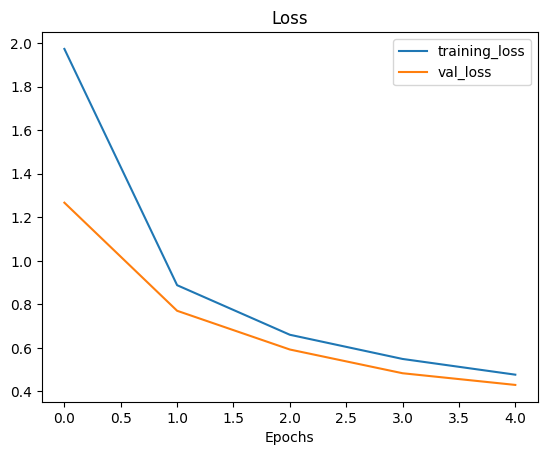

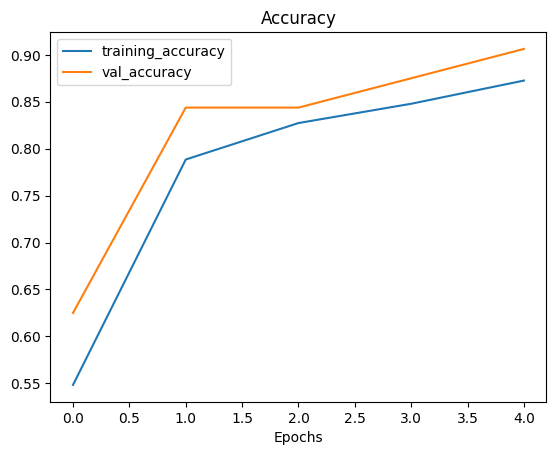

In [27]:
plot_loss_curves(base_model_history_b0)

In [28]:
model_b0.save("model/base_model_b0.h5")

## EfficientNetB1 

In [29]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b1 = tf.keras.applications.EfficientNetB1(include_top=False)
base_model_b1.trainable = False

# Setup model architecture with trainable top layres
inputs_b1 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b1) 
x = base_model_b1(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b1 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b1 = tf.keras.Model(inputs_b1, outputs_b1)

In [30]:
# Compile the model
model_b1.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [31]:
model_b1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                46116     
                                                                 
Total params: 6,621,355
Trainable params: 46,116
Non-traina

In [32]:
base_model_history_b1 = model_b1.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b1")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b1/20230406-134904
Epoch 1/5


2023-04-06 13:49:09.427402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:09.528707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:09.748527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:10.795513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:10.963622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 22s - loss: 3.6274 - accuracy: 0.0437

2023-04-06 13:49:12.939770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 20s - loss: 3.4962 - accuracy: 0.0903

2023-04-06 13:49:13.725692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:13.886191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 19s - loss: 3.4437 - accuracy: 0.1023

2023-04-06 13:49:14.552956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 22s - loss: 3.3931 - accuracy: 0.1130

2023-04-06 13:49:15.149013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 20s - loss: 3.2873 - accuracy: 0.1636

2023-04-06 13:49:15.853277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 16s - loss: 2.9625 - accuracy: 0.2990

2023-04-06 13:49:18.861258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 16s - loss: 2.9371 - accuracy: 0.3044

2023-04-06 13:49:19.287362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 15s - loss: 2.8400 - accuracy: 0.3393

2023-04-06 13:49:20.012857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 12s - loss: 2.6042 - accuracy: 0.4029

2023-04-06 13:49:23.033523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/98 [==============>...............] - ETA: 11s - loss: 2.5555 - accuracy: 0.4131

2023-04-06 13:49:23.546820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:23.558029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 10s - loss: 2.4768 - accuracy: 0.4307

2023-04-06 13:49:24.500737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:24.531055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 9s - loss: 2.4275 - accuracy: 0.4461

2023-04-06 13:49:25.055591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:25.056297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 8s - loss: 2.3747 - accuracy: 0.4637

2023-04-06 13:49:25.877297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 8s - loss: 2.3606 - accuracy: 0.4673

2023-04-06 13:49:26.140911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 241ms/step - loss: 1.9843 - accuracy: 0.5554 - val_loss: 1.1112 - val_accuracy: 0.7500
Epoch 2/5


2023-04-06 13:49:35.410259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:35.504288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:35.732955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:36.707346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:36.873602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 18s - loss: 1.0108 - accuracy: 0.8125

2023-04-06 13:49:37.876928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 19s - loss: 1.0374 - accuracy: 0.7882

2023-04-06 13:49:38.667960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:38.817474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 19s - loss: 1.0217 - accuracy: 0.7943

2023-04-06 13:49:39.534253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 20s - loss: 1.0069 - accuracy: 0.7946

2023-04-06 13:49:40.038831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 18s - loss: 1.0171 - accuracy: 0.7794

2023-04-06 13:49:40.488942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 16s - loss: 0.9816 - accuracy: 0.7823

2023-04-06 13:49:43.743335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 15s - loss: 0.9650 - accuracy: 0.7903

2023-04-06 13:49:44.205531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 14s - loss: 0.9793 - accuracy: 0.7830

2023-04-06 13:49:44.868017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 11s - loss: 0.9494 - accuracy: 0.7859

2023-04-06 13:49:47.661629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/98 [==============>...............] - ETA: 10s - loss: 0.9503 - accuracy: 0.7831

2023-04-06 13:49:48.165769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:48.166703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.9483 - accuracy: 0.7858

2023-04-06 13:49:48.973347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:49.004009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 8s - loss: 0.9391 - accuracy: 0.7866

2023-04-06 13:49:49.631288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:49.632443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 8s - loss: 0.9341 - accuracy: 0.7889

2023-04-06 13:49:50.284732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 7s - loss: 0.9303 - accuracy: 0.7912

2023-04-06 13:49:50.749156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 23s 219ms/step - loss: 0.8806 - accuracy: 0.7907 - val_loss: 0.7077 - val_accuracy: 0.8438
Epoch 3/5


2023-04-06 13:49:58.447059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:58.535139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:58.747929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:59.716505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:49:59.875314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 21s - loss: 0.6723 - accuracy: 0.8188

2023-04-06 13:50:00.997872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 19s - loss: 0.7237 - accuracy: 0.8160

2023-04-06 13:50:01.645344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:01.801678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 18s - loss: 0.6960 - accuracy: 0.8203

2023-04-06 13:50:02.482403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 18s - loss: 0.6889 - accuracy: 0.8214

2023-04-06 13:50:02.770957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.8199

2023-04-06 13:50:03.231685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 13s - loss: 0.7126 - accuracy: 0.8093

2023-04-06 13:50:05.500265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 12s - loss: 0.7091 - accuracy: 0.8115

2023-04-06 13:50:05.773397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 12s - loss: 0.7020 - accuracy: 0.8153

2023-04-06 13:50:06.445989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 9s - loss: 0.6820 - accuracy: 0.8262

2023-04-06 13:50:08.723450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/98 [==============>...............] - ETA: 9s - loss: 0.6813 - accuracy: 0.8244

2023-04-06 13:50:09.113724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:09.127146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.6869 - accuracy: 0.8244

2023-04-06 13:50:10.054993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:10.086207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.8217

2023-04-06 13:50:10.703307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:10.703984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 6s - loss: 0.6829 - accuracy: 0.8226

2023-04-06 13:50:11.439521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 6s - loss: 0.6899 - accuracy: 0.8209

2023-04-06 13:50:11.716970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 21s 200ms/step - loss: 0.6587 - accuracy: 0.8254 - val_loss: 0.5624 - val_accuracy: 0.8438
Epoch 4/5


2023-04-06 13:50:19.564721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:19.656767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:19.871490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:20.870966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:21.029110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 20s - loss: 0.5180 - accuracy: 0.8828

2023-04-06 13:50:22.060536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 20s - loss: 0.5488 - accuracy: 0.8594

2023-04-06 13:50:22.795181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:22.941389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 20s - loss: 0.5525 - accuracy: 0.8630

2023-04-06 13:50:23.938425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 19s - loss: 0.5623 - accuracy: 0.8549

2023-04-06 13:50:24.218902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 17s - loss: 0.5594 - accuracy: 0.8594

2023-04-06 13:50:24.730082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 14s - loss: 0.5817 - accuracy: 0.8552

2023-04-06 13:50:27.211873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 14s - loss: 0.5843 - accuracy: 0.8525

2023-04-06 13:50:27.717598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 13s - loss: 0.5796 - accuracy: 0.8536

2023-04-06 13:50:28.374316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 10s - loss: 0.5663 - accuracy: 0.8527

2023-04-06 13:50:31.352979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 10s - loss: 0.5642 - accuracy: 0.8542

2023-04-06 13:50:31.960083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:31.961590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 8s - loss: 0.5657 - accuracy: 0.8542

2023-04-06 13:50:33.023008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:33.054410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 7s - loss: 0.5630 - accuracy: 0.8560

2023-04-06 13:50:33.544330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:33.544889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 7s - loss: 0.5606 - accuracy: 0.8545

2023-04-06 13:50:34.043513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.5627 - accuracy: 0.8543

2023-04-06 13:50:34.300036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 22s 210ms/step - loss: 0.5515 - accuracy: 0.8520 - val_loss: 0.5023 - val_accuracy: 0.8750
Epoch 5/5


2023-04-06 13:50:41.610332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:41.709961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:41.927338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:42.925128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:43.086968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 16s - loss: 0.5242 - accuracy: 0.8687

2023-04-06 13:50:44.147153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 16s - loss: 0.4747 - accuracy: 0.8924

2023-04-06 13:50:44.750351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:44.899195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 18s - loss: 0.4805 - accuracy: 0.8776

2023-04-06 13:50:45.594227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 17s - loss: 0.4647 - accuracy: 0.8846

2023-04-06 13:50:45.967213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 17s - loss: 0.4502 - accuracy: 0.8934

2023-04-06 13:50:46.708771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 13s - loss: 0.4799 - accuracy: 0.8793

2023-04-06 13:50:48.863769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 13s - loss: 0.4896 - accuracy: 0.8771

2023-04-06 13:50:49.096211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 12s - loss: 0.4858 - accuracy: 0.8787

2023-04-06 13:50:49.768738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 10s - loss: 0.4812 - accuracy: 0.8743

2023-04-06 13:50:52.761090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 9s - loss: 0.4812 - accuracy: 0.8744 

2023-04-06 13:50:53.157200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:53.160162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.4884 - accuracy: 0.8733

2023-04-06 13:50:54.414495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:54.446176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 8s - loss: 0.4947 - accuracy: 0.8712

2023-04-06 13:50:55.079916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:50:55.080624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 7s - loss: 0.4867 - accuracy: 0.8720

2023-04-06 13:50:55.852898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 7s - loss: 0.4859 - accuracy: 0.8720

2023-04-06 13:50:56.073536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 22s 205ms/step - loss: 0.4766 - accuracy: 0.8726 - val_loss: 0.4466 - val_accuracy: 0.8750


In [33]:
# Evaluate on whole test dataset
feature_extraction_results_b1 = model_b1.evaluate(test_data)
feature_extraction_results_b1

 5/12 [===========>..................] - ETA: 0s - loss: 0.4419 - accuracy: 0.8438

2023-04-06 13:51:04.052917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.3639 - accuracy: 0.8795

2023-04-06 13:51:04.380085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 2s 146ms/step - loss: 0.3327 - accuracy: 0.9053


[0.33268651366233826, 0.9052924513816833]

In [34]:
print('The accuracy of the base model is ',feature_extraction_results_b1[1])

The accuracy of the base model is  0.9052924513816833


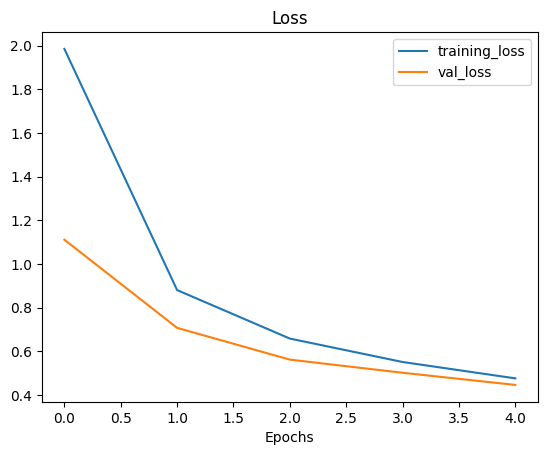

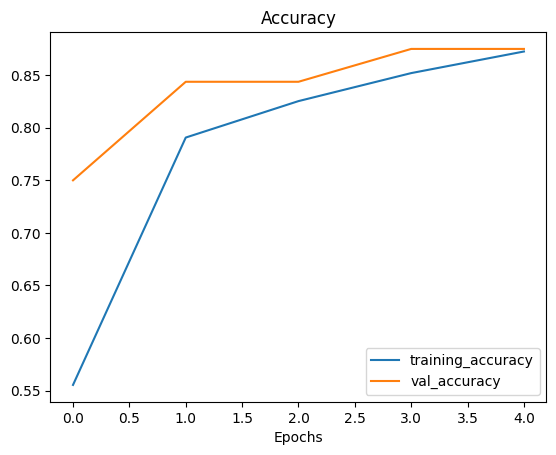

In [35]:
plot_loss_curves(base_model_history_b1)

In [36]:
model_b1.save("model/base_model_b1.h5")

## EfficientNetB2

In [37]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b2 = tf.keras.applications.EfficientNetB2(include_top=False)
base_model_b2.trainable = False

# Setup model architecture with trainable top layres
inputs_b2 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b2) 
x = base_model_b2(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b2 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b2 = tf.keras.Model(inputs_b2, outputs_b2)

In [38]:
# Compile the model
model_b2.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [39]:
model_b2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 global_avg_pool_layer (Glob  (None, 1408)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                50724     
                                                                 
Total params: 7,819,293
Trainable params: 50,724
Non-traina

In [40]:
base_model_history_b2 = model_b2.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b2")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b2/20230406-135107
Epoch 1/5


2023-04-06 13:51:13.018007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:13.125614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:13.350161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:14.366606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:14.538404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 48s - loss: 3.5795 - accuracy: 0.0938

2023-04-06 13:51:17.393127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 43s - loss: 3.5519 - accuracy: 0.0859

2023-04-06 13:51:19.068972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:19.225010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


11/98 [==>...........................] - ETA: 36s - loss: 3.4455 - accuracy: 0.1222

2023-04-06 13:51:20.034734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 35s - loss: 3.4115 - accuracy: 0.1418

2023-04-06 13:51:20.670647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 30s - loss: 3.3114 - accuracy: 0.1746

2023-04-06 13:51:21.440429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 23s - loss: 3.0086 - accuracy: 0.3094

2023-04-06 13:51:25.389040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 22s - loss: 2.9776 - accuracy: 0.3246

2023-04-06 13:51:25.847471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 21s - loss: 2.9013 - accuracy: 0.3456

2023-04-06 13:51:26.837925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 16s - loss: 2.5985 - accuracy: 0.4292

2023-04-06 13:51:31.276468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 14s - loss: 2.5474 - accuracy: 0.4399

2023-04-06 13:51:32.014404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:32.014927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 12s - loss: 2.4655 - accuracy: 0.4611

2023-04-06 13:51:32.988284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:33.031508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 11s - loss: 2.4409 - accuracy: 0.4650

2023-04-06 13:51:33.602420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:33.603281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 10s - loss: 2.3864 - accuracy: 0.4767

2023-04-06 13:51:34.854969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 10s - loss: 2.3606 - accuracy: 0.4841

2023-04-06 13:51:35.195793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 37s 297ms/step - loss: 2.0066 - accuracy: 0.5586 - val_loss: 1.1672 - val_accuracy: 0.6875
Epoch 2/5


2023-04-06 13:51:44.491036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:44.611498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:44.835549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:45.871673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:46.042123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 13s - loss: 1.0377 - accuracy: 0.7875

2023-04-06 13:51:46.850196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 16s - loss: 1.0461 - accuracy: 0.7812

2023-04-06 13:51:47.382275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:47.543166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 18s - loss: 1.0292 - accuracy: 0.7760

2023-04-06 13:51:48.386611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:48.502373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/98 [===>..........................] - ETA: 18s - loss: 1.0311 - accuracy: 0.7833

2023-04-06 13:51:49.227252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


27/98 [=======>......................] - ETA: 13s - loss: 1.0446 - accuracy: 0.7546

2023-04-06 13:51:51.378808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 13s - loss: 1.0503 - accuracy: 0.7468

2023-04-06 13:51:51.869204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 13s - loss: 1.0257 - accuracy: 0.7547

2023-04-06 13:51:52.651792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 10s - loss: 0.9873 - accuracy: 0.7666

2023-04-06 13:51:55.534288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/98 [==============>...............] - ETA: 9s - loss: 0.9784 - accuracy: 0.7694 

2023-04-06 13:51:56.211021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:56.212172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 9s - loss: 0.9622 - accuracy: 0.7767

2023-04-06 13:51:57.618594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:57.652551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 8s - loss: 0.9529 - accuracy: 0.7780

2023-04-06 13:51:58.423329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:51:58.424768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 7s - loss: 0.9481 - accuracy: 0.7767

2023-04-06 13:51:59.218576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 7s - loss: 0.9438 - accuracy: 0.7783

2023-04-06 13:51:59.462679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 22s 205ms/step - loss: 0.8857 - accuracy: 0.7900 - val_loss: 0.7596 - val_accuracy: 0.8125
Epoch 3/5


2023-04-06 13:52:06.222711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:06.333933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:06.557859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:07.586423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:07.757478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 13s - loss: 0.6799 - accuracy: 0.8177

2023-04-06 13:52:08.584801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 14s - loss: 0.6854 - accuracy: 0.8229

2023-04-06 13:52:09.092972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:09.245542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 16s - loss: 0.6812 - accuracy: 0.8281

2023-04-06 13:52:09.928494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 15s - loss: 0.6768 - accuracy: 0.8304

2023-04-06 13:52:10.259616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 14s - loss: 0.6804 - accuracy: 0.8242

2023-04-06 13:52:10.686877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 13s - loss: 0.7110 - accuracy: 0.8114

2023-04-06 13:52:13.135940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 12s - loss: 0.7137 - accuracy: 0.8115

2023-04-06 13:52:13.377247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 11s - loss: 0.6970 - accuracy: 0.8170

2023-04-06 13:52:14.073657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.8125

2023-04-06 13:52:16.357441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/98 [==============>...............] - ETA: 8s - loss: 0.6935 - accuracy: 0.8138

2023-04-06 13:52:16.757045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:16.770943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 7s - loss: 0.6890 - accuracy: 0.8176

2023-04-06 13:52:17.516558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:17.545203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 7s - loss: 0.6868 - accuracy: 0.8195

2023-04-06 13:52:18.064117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:18.064990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 6s - loss: 0.6843 - accuracy: 0.8196

2023-04-06 13:52:18.843343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 6s - loss: 0.6811 - accuracy: 0.8209

2023-04-06 13:52:19.071630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 20s 186ms/step - loss: 0.6542 - accuracy: 0.8302 - val_loss: 0.6143 - val_accuracy: 0.8125
Epoch 4/5


2023-04-06 13:52:26.078706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:26.182559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:26.394299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:27.400040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:27.569626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 12s - loss: 0.5365 - accuracy: 0.8802

2023-04-06 13:52:28.317727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 13s - loss: 0.5837 - accuracy: 0.8594

2023-04-06 13:52:28.661865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:28.818003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 14s - loss: 0.5668 - accuracy: 0.8568

2023-04-06 13:52:29.480684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 13s - loss: 0.5718 - accuracy: 0.8571

2023-04-06 13:52:29.738867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 12s - loss: 0.5695 - accuracy: 0.8585

2023-04-06 13:52:30.106716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 11s - loss: 0.5873 - accuracy: 0.8527

2023-04-06 13:52:32.196397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 11s - loss: 0.5805 - accuracy: 0.8524

2023-04-06 13:52:32.500462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 11s - loss: 0.5802 - accuracy: 0.8496

2023-04-06 13:52:33.299633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 8s - loss: 0.5749 - accuracy: 0.8471

2023-04-06 13:52:35.748008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/98 [==============>...............] - ETA: 8s - loss: 0.5821 - accuracy: 0.8444

2023-04-06 13:52:36.190750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:36.191550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


54/98 [===============>..............] - ETA: 7s - loss: 0.5743 - accuracy: 0.8490

2023-04-06 13:52:37.122041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:37.157580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 7s - loss: 0.5766 - accuracy: 0.8454

2023-04-06 13:52:37.780678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:37.781131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 6s - loss: 0.5708 - accuracy: 0.8462

2023-04-06 13:52:38.485338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 5s - loss: 0.5693 - accuracy: 0.8467

2023-04-06 13:52:38.704235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 19s 181ms/step - loss: 0.5499 - accuracy: 0.8517 - val_loss: 0.5495 - val_accuracy: 0.8750
Epoch 5/5


2023-04-06 13:52:45.326506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:45.409830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:45.652751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:46.673884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:46.840796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 17s - loss: 0.5134 - accuracy: 0.8698

2023-04-06 13:52:47.802263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 15s - loss: 0.5022 - accuracy: 0.8633

2023-04-06 13:52:48.111125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:48.276039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 16s - loss: 0.4676 - accuracy: 0.8776

2023-04-06 13:52:48.938002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 15s - loss: 0.4728 - accuracy: 0.8750

2023-04-06 13:52:49.185170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 14s - loss: 0.4719 - accuracy: 0.8768

2023-04-06 13:52:49.701800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 13s - loss: 0.5050 - accuracy: 0.8685

2023-04-06 13:52:52.231544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 12s - loss: 0.5155 - accuracy: 0.8629

2023-04-06 13:52:52.516280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 11s - loss: 0.5108 - accuracy: 0.8589

2023-04-06 13:52:53.180020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 9s - loss: 0.5118 - accuracy: 0.8577

2023-04-06 13:52:55.503389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 9s - loss: 0.5171 - accuracy: 0.8552

2023-04-06 13:52:55.945645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:55.946333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


55/98 [===============>..............] - ETA: 8s - loss: 0.5215 - accuracy: 0.8517

2023-04-06 13:52:57.272202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:57.306638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 7s - loss: 0.5207 - accuracy: 0.8545

2023-04-06 13:52:57.758771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:52:57.760169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


62/98 [=================>............] - ETA: 6s - loss: 0.5103 - accuracy: 0.8574

2023-04-06 13:52:58.499874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 6s - loss: 0.5091 - accuracy: 0.8558

2023-04-06 13:52:58.726896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 20s 187ms/step - loss: 0.4969 - accuracy: 0.8610 - val_loss: 0.5293 - val_accuracy: 0.8750


In [41]:
# Evaluate on whole test dataset
feature_extraction_results_b2 = model_b2.evaluate(test_data)
feature_extraction_results_b2

 5/12 [===========>..................] - ETA: 1s - loss: 0.4533 - accuracy: 0.8000

2023-04-06 13:53:05.916299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.3877 - accuracy: 0.8348

2023-04-06 13:53:06.233411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 2s 169ms/step - loss: 0.3391 - accuracy: 0.8747


[0.33911755681037903, 0.8746517896652222]

In [42]:
print('The accuracy of the base model is ',feature_extraction_results_b2[1])

The accuracy of the base model is  0.8746517896652222


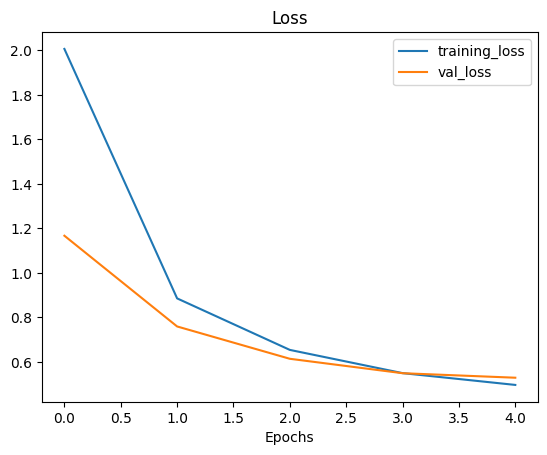

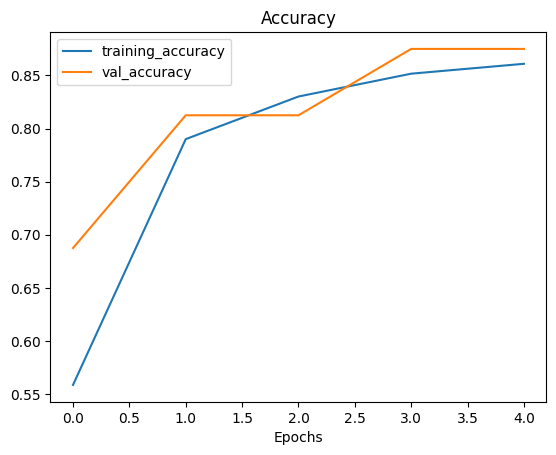

In [43]:
plot_loss_curves(base_model_history_b2)

In [44]:
model_b2.save("model/base_model_b2.h5")

## EfficientNetB3

In [45]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b3 = tf.keras.applications.EfficientNetB3(include_top=False)
base_model_b3.trainable = False

# Setup model architecture with trainable top layres
inputs_b3 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b3) 
x = base_model_b3(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b3 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b3 = tf.keras.Model(inputs_b3, outputs_b3)

In [46]:
# Compile the model
model_b3.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [47]:
model_b3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_avg_pool_layer (Glob  (None, 1536)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                55332     
                                                                 
Total params: 10,838,867
Trainable params: 55,332
Non-train

In [48]:
base_model_history_b3 = model_b3.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b3")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b3/20230406-135309
Epoch 1/5


2023-04-06 13:53:15.180642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:15.275732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:15.481619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:16.473467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:16.634490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 51s - loss: 3.5425 - accuracy: 0.0781    

2023-04-06 13:53:19.692934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 59s - loss: 3.5000 - accuracy: 0.0859 

2023-04-06 13:53:22.462683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:22.635609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 54s - loss: 3.3677 - accuracy: 0.1510

2023-04-06 13:53:24.894249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 52s - loss: 3.3071 - accuracy: 0.1741

2023-04-06 13:53:25.950574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 50s - loss: 3.2242 - accuracy: 0.2077

2023-04-06 13:53:27.792473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 36s - loss: 2.8987 - accuracy: 0.3229

2023-04-06 13:53:33.419686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 35s - loss: 2.8545 - accuracy: 0.3369

2023-04-06 13:53:34.496428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 33s - loss: 2.7948 - accuracy: 0.3491

2023-04-06 13:53:35.748386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 24s - loss: 2.5198 - accuracy: 0.4310

2023-04-06 13:53:40.706750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 22s - loss: 2.4723 - accuracy: 0.4430

2023-04-06 13:53:41.615108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:41.615544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 19s - loss: 2.3902 - accuracy: 0.4637

2023-04-06 13:53:43.536802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:43.572709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 18s - loss: 2.3363 - accuracy: 0.4746

2023-04-06 13:53:45.216168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:53:45.217040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 16s - loss: 2.2759 - accuracy: 0.4906

2023-04-06 13:53:46.788999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 15s - loss: 2.2622 - accuracy: 0.4941

2023-04-06 13:53:47.197686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 50s 438ms/step - loss: 1.9016 - accuracy: 0.5708 - val_loss: 1.2552 - val_accuracy: 0.6875
Epoch 2/5


2023-04-06 13:54:00.386473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:00.487789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:00.709977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:01.674883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:01.847096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 45s - loss: 0.9879 - accuracy: 0.7812

2023-04-06 13:54:03.783344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 41s - loss: 0.9678 - accuracy: 0.7656

2023-04-06 13:54:05.358508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:05.528780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 34s - loss: 0.9618 - accuracy: 0.7656

2023-04-06 13:54:06.577473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 32s - loss: 0.9435 - accuracy: 0.7768

2023-04-06 13:54:07.169816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 30s - loss: 0.9629 - accuracy: 0.7665

2023-04-06 13:54:08.211786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 25s - loss: 0.9465 - accuracy: 0.7759

2023-04-06 13:54:12.432065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 24s - loss: 0.9347 - accuracy: 0.7782

2023-04-06 13:54:13.074816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 23s - loss: 0.9305 - accuracy: 0.7785

2023-04-06 13:54:14.426279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 17s - loss: 0.8958 - accuracy: 0.7838

2023-04-06 13:54:18.927198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 16s - loss: 0.8951 - accuracy: 0.7837

2023-04-06 13:54:19.691600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:19.693099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 14s - loss: 0.8911 - accuracy: 0.7835

2023-04-06 13:54:21.594812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:21.633340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 13s - loss: 0.8857 - accuracy: 0.7844

2023-04-06 13:54:22.634398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:22.635280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 12s - loss: 0.8757 - accuracy: 0.7867

2023-04-06 13:54:23.675126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 11s - loss: 0.8723 - accuracy: 0.7865

2023-04-06 13:54:24.241949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 35s 340ms/step - loss: 0.8227 - accuracy: 0.7926 - val_loss: 0.8585 - val_accuracy: 0.7812
Epoch 3/5


2023-04-06 13:54:35.206185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:35.297593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:35.521777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:36.536237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:36.697582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 29s - loss: 0.6976 - accuracy: 0.8313

2023-04-06 13:54:38.328879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 27s - loss: 0.7009 - accuracy: 0.8125

2023-04-06 13:54:39.235665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:39.386627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 29s - loss: 0.6864 - accuracy: 0.8229

2023-04-06 13:54:40.934324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/98 [===>..........................] - ETA: 28s - loss: 0.6905 - accuracy: 0.8229

2023-04-06 13:54:41.786119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 27s - loss: 0.7036 - accuracy: 0.8162

2023-04-06 13:54:42.540182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 22s - loss: 0.6835 - accuracy: 0.8254

2023-04-06 13:54:46.476225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 22s - loss: 0.6825 - accuracy: 0.8246

2023-04-06 13:54:47.098633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 21s - loss: 0.6869 - accuracy: 0.8226

2023-04-06 13:54:47.992358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 15s - loss: 0.6594 - accuracy: 0.8259

2023-04-06 13:54:52.357466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 14s - loss: 0.6570 - accuracy: 0.8254

2023-04-06 13:54:53.045903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:53.046637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 13s - loss: 0.6659 - accuracy: 0.8231

2023-04-06 13:54:54.646367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:54.680081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 12s - loss: 0.6677 - accuracy: 0.8220

2023-04-06 13:54:56.011913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:54:56.012758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 11s - loss: 0.6673 - accuracy: 0.8204

2023-04-06 13:54:57.060196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 10s - loss: 0.6664 - accuracy: 0.8178

2023-04-06 13:54:57.425422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 32s 310ms/step - loss: 0.6354 - accuracy: 0.8292 - val_loss: 0.6936 - val_accuracy: 0.7500
Epoch 4/5


2023-04-06 13:55:07.225086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:07.322622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:07.531653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:08.518406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:08.682472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 32s - loss: 0.5820 - accuracy: 0.8516

2023-04-06 13:55:10.264198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 29s - loss: 0.5914 - accuracy: 0.8681

2023-04-06 13:55:11.572223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:11.719270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 28s - loss: 0.5714 - accuracy: 0.8646

2023-04-06 13:55:12.454627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/98 [==>...........................] - ETA: 29s - loss: 0.5592 - accuracy: 0.8678

2023-04-06 13:55:13.175826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 26s - loss: 0.5528 - accuracy: 0.8621

2023-04-06 13:55:14.108234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 22s - loss: 0.5778 - accuracy: 0.8481

2023-04-06 13:55:18.108975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 20s - loss: 0.5708 - accuracy: 0.8477

2023-04-06 13:55:18.699424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 19s - loss: 0.5623 - accuracy: 0.8509

2023-04-06 13:55:19.517287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 15s - loss: 0.5409 - accuracy: 0.8540

2023-04-06 13:55:23.592279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 14s - loss: 0.5428 - accuracy: 0.8534

2023-04-06 13:55:24.491992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:24.493828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 12s - loss: 0.5490 - accuracy: 0.8510

2023-04-06 13:55:25.561799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:25.595889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 11s - loss: 0.5485 - accuracy: 0.8490

2023-04-06 13:55:26.538549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:26.539159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 10s - loss: 0.5497 - accuracy: 0.8482

2023-04-06 13:55:27.845345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 9s - loss: 0.5534 - accuracy: 0.8452 

2023-04-06 13:55:28.194099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 30s 290ms/step - loss: 0.5362 - accuracy: 0.8465 - val_loss: 0.5798 - val_accuracy: 0.8438
Epoch 5/5


2023-04-06 13:55:37.291552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:37.375690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:37.598895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:38.568597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:38.731575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 22s - loss: 0.4569 - accuracy: 0.8625

2023-04-06 13:55:39.970525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 24s - loss: 0.4569 - accuracy: 0.8633

2023-04-06 13:55:41.015749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:41.170801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 24s - loss: 0.4486 - accuracy: 0.8750

2023-04-06 13:55:42.275017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 24s - loss: 0.4403 - accuracy: 0.8728

2023-04-06 13:55:42.840037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 24s - loss: 0.4452 - accuracy: 0.8658

2023-04-06 13:55:43.854058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 20s - loss: 0.4888 - accuracy: 0.8599

2023-04-06 13:55:47.492030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 20s - loss: 0.4942 - accuracy: 0.8589

2023-04-06 13:55:48.253525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 18s - loss: 0.4970 - accuracy: 0.8571

2023-04-06 13:55:48.898941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 13s - loss: 0.4830 - accuracy: 0.8597

2023-04-06 13:55:52.546017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 13s - loss: 0.4857 - accuracy: 0.8591

2023-04-06 13:55:53.665164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:53.666014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 12s - loss: 0.4865 - accuracy: 0.8588

2023-04-06 13:55:55.014056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:55.044074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 11s - loss: 0.4844 - accuracy: 0.8583

2023-04-06 13:55:56.160942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:55:56.161535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 10s - loss: 0.4832 - accuracy: 0.8571

2023-04-06 13:55:56.948491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 9s - loss: 0.4828 - accuracy: 0.8582

2023-04-06 13:55:57.366801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 298ms/step - loss: 0.4649 - accuracy: 0.8607 - val_loss: 0.5382 - val_accuracy: 0.8750


In [49]:
# Evaluate on whole test dataset
feature_extraction_results_b3 = model_b3.evaluate(test_data)
feature_extraction_results_b3

 5/12 [===========>..................] - ETA: 1s - loss: 0.4277 - accuracy: 0.8562

2023-04-06 13:56:08.911062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.3514 - accuracy: 0.8929

2023-04-06 13:56:09.236241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 2s 192ms/step - loss: 0.3188 - accuracy: 0.9081


[0.31882235407829285, 0.9080780148506165]

In [50]:
print('The accuracy of the base model is ',feature_extraction_results_b3[1])

The accuracy of the base model is  0.9080780148506165


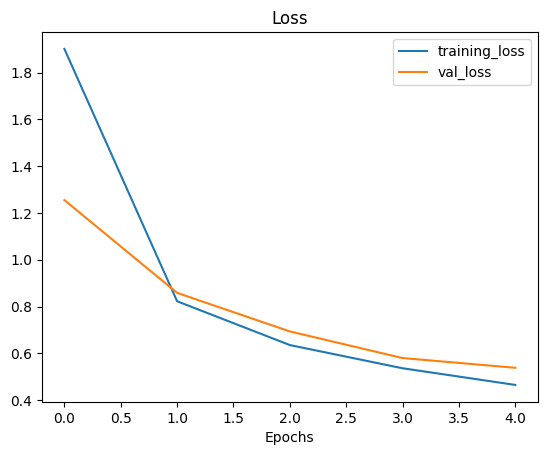

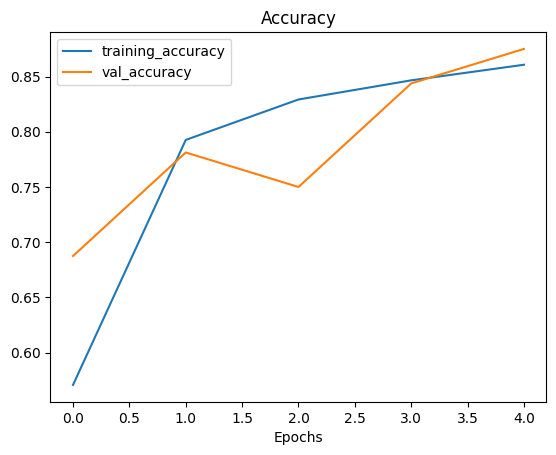

In [51]:
plot_loss_curves(base_model_history_b3)

In [52]:
model_b3.save("model/base_model_b3.h5")

## EfficientNetB4

In [53]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b4 = tf.keras.applications.EfficientNetB4(include_top=False)
base_model_b4.trainable = False

# Setup model architecture with trainable top layres
inputs_b4 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b4) 
x = base_model_b4(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b4 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b4 = tf.keras.Model(inputs_b4, outputs_b4)

In [54]:
# Compile the model
model_b4.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [55]:
model_b4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_avg_pool_layer (Glob  (None, 1792)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                64548     
                                                                 
Total params: 17,738,371
Trainable params: 64,548
Non-train

In [56]:
base_model_history_b4 = model_b4.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b4")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b4/20230406-135613
Epoch 1/5


2023-04-06 13:56:20.241630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:20.339585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:20.572559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:21.577817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:21.735032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 1:09 - loss: 3.6216 - accuracy: 0.0391 

2023-04-06 13:56:25.271718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 1:05 - loss: 3.4771 - accuracy: 0.1055

2023-04-06 13:56:27.952766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:28.101013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 55s - loss: 3.3763 - accuracy: 0.1354

2023-04-06 13:56:30.022436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 54s - loss: 3.3086 - accuracy: 0.1652

2023-04-06 13:56:31.363215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 47s - loss: 3.2251 - accuracy: 0.2059

2023-04-06 13:56:32.264976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 36s - loss: 2.8947 - accuracy: 0.3385

2023-04-06 13:56:38.337119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 34s - loss: 2.8564 - accuracy: 0.3496

2023-04-06 13:56:38.954331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 32s - loss: 2.7861 - accuracy: 0.3741

2023-04-06 13:56:40.402565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 24s - loss: 2.5122 - accuracy: 0.4505

2023-04-06 13:56:46.131880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 22s - loss: 2.4616 - accuracy: 0.4608

2023-04-06 13:56:46.895373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:46.896750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 20s - loss: 2.3877 - accuracy: 0.4771

2023-04-06 13:56:49.159632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:49.195691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 18s - loss: 2.3463 - accuracy: 0.4841

2023-04-06 13:56:50.540389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:56:50.541385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 16s - loss: 2.2964 - accuracy: 0.4906

2023-04-06 13:56:51.826600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 15s - loss: 2.2650 - accuracy: 0.4986

2023-04-06 13:56:52.583674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 53s 453ms/step - loss: 1.9235 - accuracy: 0.5676 - val_loss: 1.0575 - val_accuracy: 0.8125
Epoch 2/5


2023-04-06 13:57:06.846729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:06.941483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:07.161899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:08.179746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:08.344415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 25s - loss: 1.0474 - accuracy: 0.7250

2023-04-06 13:57:10.005690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 1.0232 - accuracy: 0.7305

2023-04-06 13:57:11.240719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:11.391364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 27s - loss: 1.0301 - accuracy: 0.7396

2023-04-06 13:57:12.471521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 29s - loss: 1.0452 - accuracy: 0.7299

2023-04-06 13:57:13.463487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 27s - loss: 1.0386 - accuracy: 0.7316

2023-04-06 13:57:14.427124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 23s - loss: 1.0046 - accuracy: 0.7500

2023-04-06 13:57:19.204673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 23s - loss: 1.0004 - accuracy: 0.7500

2023-04-06 13:57:19.917558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 21s - loss: 0.9909 - accuracy: 0.7571

2023-04-06 13:57:20.726340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 16s - loss: 0.9710 - accuracy: 0.7577

2023-04-06 13:57:24.531415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 15s - loss: 0.9559 - accuracy: 0.7616

2023-04-06 13:57:25.757064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:25.757870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 13s - loss: 0.9533 - accuracy: 0.7632

2023-04-06 13:57:27.394532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:27.426629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 13s - loss: 0.9511 - accuracy: 0.7617

2023-04-06 13:57:28.393581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:28.394184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 11s - loss: 0.9397 - accuracy: 0.7644

2023-04-06 13:57:29.948127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 11s - loss: 0.9429 - accuracy: 0.7625

2023-04-06 13:57:30.328374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 34s 326ms/step - loss: 0.8944 - accuracy: 0.7692 - val_loss: 0.7713 - val_accuracy: 0.8438
Epoch 3/5


2023-04-06 13:57:40.651025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:40.748211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:40.963107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:41.951227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:42.113798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 24s - loss: 0.8142 - accuracy: 0.7437

2023-04-06 13:57:43.337745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 22s - loss: 0.7622 - accuracy: 0.7617

2023-04-06 13:57:44.057256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:44.207340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 24s - loss: 0.7691 - accuracy: 0.7760

2023-04-06 13:57:45.477960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 25s - loss: 0.7713 - accuracy: 0.7723

2023-04-06 13:57:46.180675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 23s - loss: 0.7765 - accuracy: 0.7739

2023-04-06 13:57:47.015965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 20s - loss: 0.7630 - accuracy: 0.7740

2023-04-06 13:57:51.029639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 0.7564 - accuracy: 0.7756

2023-04-06 13:57:51.800792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


36/98 [==========>...................] - ETA: 19s - loss: 0.7543 - accuracy: 0.7795

2023-04-06 13:57:52.910092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 15s - loss: 0.7288 - accuracy: 0.7908

2023-04-06 13:57:56.875605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 14s - loss: 0.7277 - accuracy: 0.7923

2023-04-06 13:57:57.737451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:57.738626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 12s - loss: 0.7195 - accuracy: 0.7924

2023-04-06 13:57:59.126460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:57:59.168171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 11s - loss: 0.7245 - accuracy: 0.7891

2023-04-06 13:58:00.226621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:00.227311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 10s - loss: 0.7249 - accuracy: 0.7891

2023-04-06 13:58:01.534206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 10s - loss: 0.7232 - accuracy: 0.7885

2023-04-06 13:58:01.808778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 32s 309ms/step - loss: 0.6928 - accuracy: 0.7984 - val_loss: 0.6380 - val_accuracy: 0.8438
Epoch 4/5


2023-04-06 13:58:12.361014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:12.465698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:12.671522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:13.632038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:13.802146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 25s - loss: 0.5510 - accuracy: 0.8438

2023-04-06 13:58:15.316252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 21s - loss: 0.6079 - accuracy: 0.8229

2023-04-06 13:58:16.133669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:16.293072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 21s - loss: 0.6263 - accuracy: 0.8177

2023-04-06 13:58:16.976539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 20s - loss: 0.6340 - accuracy: 0.8103

2023-04-06 13:58:17.392690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 20s - loss: 0.6432 - accuracy: 0.8027

2023-04-06 13:58:18.122854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 18s - loss: 0.6200 - accuracy: 0.8147

2023-04-06 13:58:21.735961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 17s - loss: 0.6176 - accuracy: 0.8165

2023-04-06 13:58:22.164047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 16s - loss: 0.6203 - accuracy: 0.8188

2023-04-06 13:58:22.852941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 12s - loss: 0.6006 - accuracy: 0.8221

2023-04-06 13:58:26.519444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 12s - loss: 0.5979 - accuracy: 0.8223

2023-04-06 13:58:27.162753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:27.164079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 10s - loss: 0.6011 - accuracy: 0.8209

2023-04-06 13:58:28.219419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:28.247518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 10s - loss: 0.6046 - accuracy: 0.8215

2023-04-06 13:58:29.444985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:29.445835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 9s - loss: 0.6062 - accuracy: 0.8219

2023-04-06 13:58:30.522190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 8s - loss: 0.6078 - accuracy: 0.8221

2023-04-06 13:58:30.884690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 29s 277ms/step - loss: 0.5945 - accuracy: 0.8244 - val_loss: 0.6325 - val_accuracy: 0.7500
Epoch 5/5


2023-04-06 13:58:41.312115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:41.400931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:41.620247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:42.614135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:42.777165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 29s - loss: 0.6341 - accuracy: 0.8125

2023-04-06 13:58:44.253425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 26s - loss: 0.5432 - accuracy: 0.8359

2023-04-06 13:58:45.246360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:45.393798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 23s - loss: 0.5280 - accuracy: 0.8490

2023-04-06 13:58:46.119783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 21s - loss: 0.5216 - accuracy: 0.8415

2023-04-06 13:58:46.382709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/98 [===>..........................] - ETA: 22s - loss: 0.5220 - accuracy: 0.8398

2023-04-06 13:58:47.242721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 18s - loss: 0.5489 - accuracy: 0.8308

2023-04-06 13:58:50.701756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 17s - loss: 0.5512 - accuracy: 0.8311

2023-04-06 13:58:51.379811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 16s - loss: 0.5473 - accuracy: 0.8348

2023-04-06 13:58:52.052021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 12s - loss: 0.5447 - accuracy: 0.8338

2023-04-06 13:58:54.684795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 12s - loss: 0.5468 - accuracy: 0.8316

2023-04-06 13:58:55.257225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:55.257530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


54/98 [===============>..............] - ETA: 11s - loss: 0.5441 - accuracy: 0.8339

2023-04-06 13:58:56.605630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:56.646337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


58/98 [================>.............] - ETA: 10s - loss: 0.5464 - accuracy: 0.8335

2023-04-06 13:58:57.440584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:58:57.441389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


61/98 [=================>............] - ETA: 9s - loss: 0.5449 - accuracy: 0.8340

2023-04-06 13:58:58.465001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 8s - loss: 0.5409 - accuracy: 0.8358

2023-04-06 13:58:58.938647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 28s 265ms/step - loss: 0.5267 - accuracy: 0.8417 - val_loss: 0.6051 - val_accuracy: 0.7500


In [57]:
# Evaluate on whole test dataset
feature_extraction_results_b4 = model_b4.evaluate(test_data)
feature_extraction_results_b4

 5/12 [===========>..................] - ETA: 1s - loss: 0.4546 - accuracy: 0.8250

2023-04-06 13:59:09.697141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s - loss: 0.3946 - accuracy: 0.8571

2023-04-06 13:59:10.020472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 2s 186ms/step - loss: 0.3622 - accuracy: 0.8886


[0.3621941804885864, 0.8885793685913086]

In [58]:
print('The accuracy of the base model is ',feature_extraction_results_b4[1])

The accuracy of the base model is  0.8885793685913086


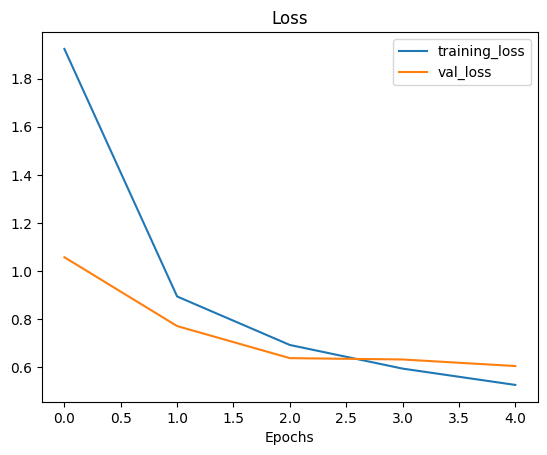

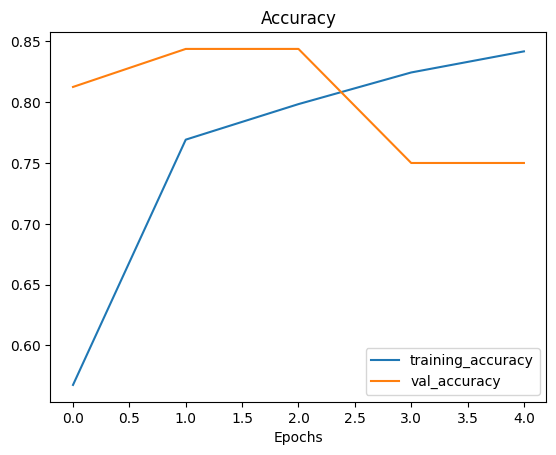

In [59]:
plot_loss_curves(base_model_history_b4)

In [60]:
model_b4.save("model/base_model_b4.h5")

## EfficientNetB5

In [61]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b5 = tf.keras.applications.EfficientNetB5(include_top=False)
base_model_b5.trainable = False

# Setup model architecture with trainable top layres
inputs_b5 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b5) 
x = base_model_b5(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b5 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b5 = tf.keras.Model(inputs_b5, outputs_b5)

In [62]:
# Compile the model
model_b5.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [63]:
model_b5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb5 (Functional)  (None, None, None, 2048)  28513527 
                                                                 
 global_avg_pool_layer (Glob  (None, 2048)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                73764     
                                                                 
Total params: 28,587,291
Trainable params: 73,764
Non-train

In [64]:
base_model_history_b5 = model_b5.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b5")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b5/20230406-135915
Epoch 1/5


2023-04-06 13:59:22.840025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:22.938496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:23.153368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:24.119254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:24.289325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:25.243753: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 13:59:25.243857: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran ou

 2/98 [..............................] - ETA: 1:03 - loss: 3.5553 - accuracy: 0.0469 

2023-04-06 13:59:26.215556: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 13:59:26.215609: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 13:59:26.248269: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 13:59:26.248341: W tensorflow/core/common_runtime/bfc_allocato

 3/98 [..............................] - ETA: 1:07 - loss: 3.5561 - accuracy: 0.0417

2023-04-06 13:59:26.972987: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 13:59:26.973056: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 4/98 [>.............................] - ETA: 1:06 - loss: 3.5443 - accuracy: 0.0781

2023-04-06 13:59:27.947211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 1:01 - loss: 3.4270 - accuracy: 0.1328

2023-04-06 13:59:30.455455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:30.601612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 55s - loss: 3.2606 - accuracy: 0.2292

2023-04-06 13:59:32.711147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 51s - loss: 3.2102 - accuracy: 0.2388

2023-04-06 13:59:33.687760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 48s - loss: 3.0967 - accuracy: 0.2812

2023-04-06 13:59:35.311944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 38s - loss: 2.7849 - accuracy: 0.3610

2023-04-06 13:59:41.468899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 36s - loss: 2.7387 - accuracy: 0.3720

2023-04-06 13:59:42.119509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 34s - loss: 2.6708 - accuracy: 0.3869

2023-04-06 13:59:43.643615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 26s - loss: 2.3951 - accuracy: 0.4518

2023-04-06 13:59:50.341837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 24s - loss: 2.3503 - accuracy: 0.4614

2023-04-06 13:59:51.767390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:51.769829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 21s - loss: 2.2824 - accuracy: 0.4782

2023-04-06 13:59:54.008970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:54.042280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 19s - loss: 2.2327 - accuracy: 0.4906

2023-04-06 13:59:55.635227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 13:59:55.635940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 17s - loss: 2.1913 - accuracy: 0.5000

2023-04-06 13:59:56.979835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 17s - loss: 2.1750 - accuracy: 0.5039

2023-04-06 13:59:57.366349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 59s 501ms/step - loss: 1.8499 - accuracy: 0.5730 - val_loss: 1.0237 - val_accuracy: 0.7188
Epoch 2/5


2023-04-06 14:00:14.277586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:14.373084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:14.593108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:15.594980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:15.775836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 38s - loss: 1.1850 - accuracy: 0.7000

2023-04-06 14:00:17.629528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 38s - loss: 1.0410 - accuracy: 0.7539

2023-04-06 14:00:19.001519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:19.162488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 34s - loss: 1.0488 - accuracy: 0.7422

2023-04-06 14:00:20.431359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 33s - loss: 1.0275 - accuracy: 0.7388

2023-04-06 14:00:21.248639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 32s - loss: 1.0180 - accuracy: 0.7408

2023-04-06 14:00:22.447555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 26s - loss: 0.9749 - accuracy: 0.7457

2023-04-06 14:00:26.720818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 25s - loss: 0.9690 - accuracy: 0.7470

2023-04-06 14:00:27.360852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 24s - loss: 0.9716 - accuracy: 0.7454

2023-04-06 14:00:28.772663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 18s - loss: 0.9530 - accuracy: 0.7441

2023-04-06 14:00:33.938952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 17s - loss: 0.9619 - accuracy: 0.7445

2023-04-06 14:00:34.966442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:34.967287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 15s - loss: 0.9679 - accuracy: 0.7422

2023-04-06 14:00:36.984511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:37.019270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 14s - loss: 0.9597 - accuracy: 0.7436

2023-04-06 14:00:37.947025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:37.947780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 13s - loss: 0.9489 - accuracy: 0.7460

2023-04-06 14:00:39.322383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 12s - loss: 0.9419 - accuracy: 0.7466

2023-04-06 14:00:39.691876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 38s 373ms/step - loss: 0.8984 - accuracy: 0.7586 - val_loss: 0.6685 - val_accuracy: 0.8125
Epoch 3/5


2023-04-06 14:00:52.259300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:52.350199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:52.568023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:53.556708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:53.713382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 27s - loss: 0.7678 - accuracy: 0.7969

2023-04-06 14:00:55.277083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 35s - loss: 0.7853 - accuracy: 0.7708

2023-04-06 14:00:57.222583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:00:57.369417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 31s - loss: 0.7449 - accuracy: 0.7891

2023-04-06 14:00:58.233289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 29s - loss: 0.7584 - accuracy: 0.7768

2023-04-06 14:00:58.851159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 29s - loss: 0.7497 - accuracy: 0.7831

2023-04-06 14:01:00.085102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 23s - loss: 0.7631 - accuracy: 0.7780

2023-04-06 14:01:03.930652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 23s - loss: 0.7724 - accuracy: 0.7812

2023-04-06 14:01:04.697175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 22s - loss: 0.7630 - accuracy: 0.7812

2023-04-06 14:01:05.983311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 17s - loss: 0.7575 - accuracy: 0.7838

2023-04-06 14:01:10.940263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 16s - loss: 0.7598 - accuracy: 0.7837

2023-04-06 14:01:11.756816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:11.758904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 14s - loss: 0.7538 - accuracy: 0.7818

2023-04-06 14:01:13.715890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:13.749881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 14s - loss: 0.7605 - accuracy: 0.7818

2023-04-06 14:01:15.184198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:15.185144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 12s - loss: 0.7509 - accuracy: 0.7847

2023-04-06 14:01:16.760311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 11s - loss: 0.7488 - accuracy: 0.7837

2023-04-06 14:01:17.126499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 38s 368ms/step - loss: 0.7327 - accuracy: 0.7836 - val_loss: 0.5848 - val_accuracy: 0.8438
Epoch 4/5


2023-04-06 14:01:29.985952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:30.084413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:30.303475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:31.360775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:31.523845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 35s - loss: 0.5800 - accuracy: 0.8375

2023-04-06 14:01:33.213550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 30s - loss: 0.6423 - accuracy: 0.8242

2023-04-06 14:01:34.112115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:34.259536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 30s - loss: 0.6206 - accuracy: 0.8359

2023-04-06 14:01:35.638540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 28s - loss: 0.6320 - accuracy: 0.8259

2023-04-06 14:01:36.098891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 26s - loss: 0.6300 - accuracy: 0.8217

2023-04-06 14:01:37.038733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 23s - loss: 0.6199 - accuracy: 0.8157

2023-04-06 14:01:41.301573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 22s - loss: 0.6139 - accuracy: 0.8216

2023-04-06 14:01:42.052950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 22s - loss: 0.6212 - accuracy: 0.8205

2023-04-06 14:01:43.746696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 17s - loss: 0.6361 - accuracy: 0.8171

2023-04-06 14:01:48.317319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 16s - loss: 0.6285 - accuracy: 0.8199

2023-04-06 14:01:49.390423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:49.390811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 14s - loss: 0.6295 - accuracy: 0.8169

2023-04-06 14:01:51.477644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:51.509581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 13s - loss: 0.6304 - accuracy: 0.8167

2023-04-06 14:01:52.322512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:01:52.323333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 12s - loss: 0.6252 - accuracy: 0.8175

2023-04-06 14:01:53.658045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 11s - loss: 0.6243 - accuracy: 0.8168

2023-04-06 14:01:54.156683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 37s 364ms/step - loss: 0.6119 - accuracy: 0.8250 - val_loss: 0.5337 - val_accuracy: 0.8750
Epoch 5/5


2023-04-06 14:02:07.114937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:07.201056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:07.405478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:08.393497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:08.555302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 23s - loss: 0.6001 - accuracy: 0.8375

2023-04-06 14:02:09.790313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 25s - loss: 0.5846 - accuracy: 0.8229

2023-04-06 14:02:10.982728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:11.151442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 30s - loss: 0.5506 - accuracy: 0.8385

2023-04-06 14:02:12.819062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 29s - loss: 0.5653 - accuracy: 0.8348

2023-04-06 14:02:13.495451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 28s - loss: 0.5414 - accuracy: 0.8438

2023-04-06 14:02:14.442504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 22s - loss: 0.5411 - accuracy: 0.8427

2023-04-06 14:02:18.035798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 21s - loss: 0.5490 - accuracy: 0.8369

2023-04-06 14:02:18.601581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 19s - loss: 0.5498 - accuracy: 0.8330

2023-04-06 14:02:19.269009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 16s - loss: 0.5644 - accuracy: 0.8278

2023-04-06 14:02:25.083298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 15s - loss: 0.5620 - accuracy: 0.8284

2023-04-06 14:02:25.799015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:25.800502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 14s - loss: 0.5592 - accuracy: 0.8315

2023-04-06 14:02:27.309389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:27.340132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 12s - loss: 0.5568 - accuracy: 0.8323

2023-04-06 14:02:28.316003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:28.316826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 11s - loss: 0.5577 - accuracy: 0.8340

2023-04-06 14:02:29.768287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:30.065132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 35s 345ms/step - loss: 0.5459 - accuracy: 0.8395 - val_loss: 0.4660 - val_accuracy: 0.8750


In [65]:
# Evaluate on whole test dataset
feature_extraction_results_b5 = model_b5.evaluate(test_data)
feature_extraction_results_b5

 5/12 [===========>..................] - ETA: 1s - loss: 0.4504 - accuracy: 0.7937

2023-04-06 14:02:43.453739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/12 [==============>...............] - ETA: 1s - loss: 0.4015 - accuracy: 0.8229

2023-04-06 14:02:43.772702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 221ms/step - loss: 0.3355 - accuracy: 0.8774


[0.33549928665161133, 0.8774373531341553]

In [66]:
print('The accuracy of the base model is ',feature_extraction_results_b5[1])

The accuracy of the base model is  0.8774373531341553


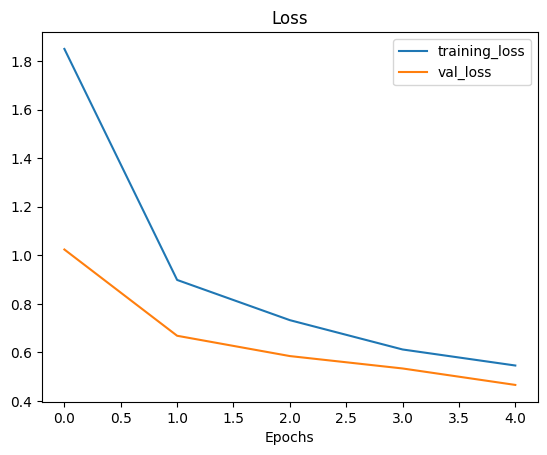

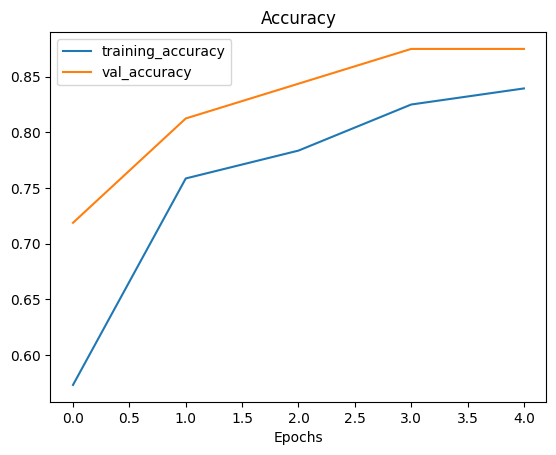

In [67]:
plot_loss_curves(base_model_history_b5)

In [68]:
model_b5.save("model/base_model_b5.h5")

## EfficientNetB6

In [69]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b6 = tf.keras.applications.EfficientNetB6(include_top=False)
base_model_b6.trainable = False

# Setup model architecture with trainable top layres
inputs_b6 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b6) 
x = base_model_b6(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b6 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b6 = tf.keras.Model(inputs_b6, outputs_b6)

In [70]:
# Compile the model
model_b6.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [71]:
model_b6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb6 (Functional)  (None, None, None, 2304)  40960143 
                                                                 
 global_avg_pool_layer (Glob  (None, 2304)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                82980     
                                                                 
Total params: 41,043,123
Trainable params: 82,980
Non-train

In [72]:
base_model_history_b6 = model_b6.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b6")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b6/20230406-140250
Epoch 1/5


2023-04-06 14:02:59.172295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:59.271164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:02:59.479806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:03:00.512214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:03:00.701665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 1:27 - loss: 3.5730 - accuracy: 0.0703

2023-04-06 14:03:05.139086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 1:17 - loss: 3.4429 - accuracy: 0.1484

2023-04-06 14:03:08.184966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:03:08.351338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 1:06 - loss: 3.3052 - accuracy: 0.2292

2023-04-06 14:03:10.735860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 1:02 - loss: 3.2539 - accuracy: 0.2545

2023-04-06 14:03:11.881584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 58s - loss: 3.1515 - accuracy: 0.2868 

2023-04-06 14:03:13.765238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 44s - loss: 2.8010 - accuracy: 0.3792

2023-04-06 14:03:21.153659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 42s - loss: 2.7585 - accuracy: 0.3877

2023-04-06 14:03:22.323112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 39s - loss: 2.6933 - accuracy: 0.3964

2023-04-06 14:03:23.695042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 30s - loss: 2.4081 - accuracy: 0.4675

2023-04-06 14:03:31.807291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 28s - loss: 2.3587 - accuracy: 0.4802

2023-04-06 14:03:33.494774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:03:33.495527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 25s - loss: 2.2786 - accuracy: 0.4956

2023-04-06 14:03:36.637687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:03:36.677278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 23s - loss: 2.2368 - accuracy: 0.5021

2023-04-06 14:03:38.400591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:03:38.401152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 20s - loss: 2.1896 - accuracy: 0.5112

2023-04-06 14:03:40.456135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 19s - loss: 2.1770 - accuracy: 0.5154

2023-04-06 14:03:40.882798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 69s 595ms/step - loss: 1.8622 - accuracy: 0.5737 - val_loss: 0.9234 - val_accuracy: 0.8750
Epoch 2/5


2023-04-06 14:03:59.989800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:00.094244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:00.304911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:01.309669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:01.474807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 39s - loss: 1.0742 - accuracy: 0.7125

2023-04-06 14:04:03.286899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 46s - loss: 1.1315 - accuracy: 0.6953

2023-04-06 14:04:05.358656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:05.542973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 42s - loss: 1.1060 - accuracy: 0.6953

2023-04-06 14:04:07.160677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 42s - loss: 1.0839 - accuracy: 0.7076

2023-04-06 14:04:08.350537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 39s - loss: 1.0601 - accuracy: 0.7114

2023-04-06 14:04:09.576906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 32s - loss: 1.0274 - accuracy: 0.7125

2023-04-06 14:04:15.618216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 31s - loss: 1.0130 - accuracy: 0.7188

2023-04-06 14:04:16.437250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 29s - loss: 1.0215 - accuracy: 0.7188

2023-04-06 14:04:17.736123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 23s - loss: 0.9869 - accuracy: 0.7331

2023-04-06 14:04:24.134763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 22s - loss: 0.9865 - accuracy: 0.7353

2023-04-06 14:04:25.782152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:25.783399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 20s - loss: 0.9760 - accuracy: 0.7349

2023-04-06 14:04:28.180637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:28.213690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 18s - loss: 0.9769 - accuracy: 0.7341

2023-04-06 14:04:29.441400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:29.442034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 16s - loss: 0.9759 - accuracy: 0.7346

2023-04-06 14:04:31.024671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 15s - loss: 0.9749 - accuracy: 0.7363

2023-04-06 14:04:31.408070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 47s 471ms/step - loss: 0.9283 - accuracy: 0.7445 - val_loss: 0.6742 - val_accuracy: 0.7812
Epoch 3/5


2023-04-06 14:04:47.452317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:47.546355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:47.767391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:48.808239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:48.980302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 47s - loss: 0.8568 - accuracy: 0.7734

2023-04-06 14:04:51.126713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 40s - loss: 0.8688 - accuracy: 0.7500

2023-04-06 14:04:52.567737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:04:52.730301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 37s - loss: 0.8208 - accuracy: 0.7526

2023-04-06 14:04:54.286411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 35s - loss: 0.8221 - accuracy: 0.7478

2023-04-06 14:04:54.984773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 35s - loss: 0.8350 - accuracy: 0.7371

2023-04-06 14:04:56.378641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 30s - loss: 0.8212 - accuracy: 0.7448

2023-04-06 14:05:02.483769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 30s - loss: 0.8206 - accuracy: 0.7471

2023-04-06 14:05:03.708817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 28s - loss: 0.8117 - accuracy: 0.7500

2023-04-06 14:05:05.008944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 22s - loss: 0.7928 - accuracy: 0.7577

2023-04-06 14:05:11.299265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 21s - loss: 0.7949 - accuracy: 0.7554

2023-04-06 14:05:12.766013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:12.766827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 18s - loss: 0.7982 - accuracy: 0.7577

2023-04-06 14:05:15.263137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:15.297430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 17s - loss: 0.7934 - accuracy: 0.7604

2023-04-06 14:05:16.306282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:16.307034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 15s - loss: 0.7787 - accuracy: 0.7646

2023-04-06 14:05:18.168309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 14s - loss: 0.7740 - accuracy: 0.7675

2023-04-06 14:05:18.931570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 47s 460ms/step - loss: 0.7519 - accuracy: 0.7775 - val_loss: 0.5259 - val_accuracy: 0.8750
Epoch 4/5


2023-04-06 14:05:34.114369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:34.199647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:34.402392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:35.388989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:35.557543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 31s - loss: 0.7011 - accuracy: 0.7812

2023-04-06 14:05:37.214571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 36s - loss: 0.6368 - accuracy: 0.8047

2023-04-06 14:05:38.892232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:39.037385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 38s - loss: 0.6305 - accuracy: 0.8203

2023-04-06 14:05:40.906201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 37s - loss: 0.6205 - accuracy: 0.8192

2023-04-06 14:05:41.796830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 37s - loss: 0.6446 - accuracy: 0.8051

2023-04-06 14:05:43.391196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 29s - loss: 0.6998 - accuracy: 0.7917

2023-04-06 14:05:48.703468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 28s - loss: 0.6974 - accuracy: 0.7910

2023-04-06 14:05:49.466306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 27s - loss: 0.6956 - accuracy: 0.7893

2023-04-06 14:05:50.842401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 21s - loss: 0.6818 - accuracy: 0.7930

2023-04-06 14:05:56.617340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 20s - loss: 0.6777 - accuracy: 0.7966

2023-04-06 14:05:58.092889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:58.093180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 18s - loss: 0.6864 - accuracy: 0.7941

2023-04-06 14:05:59.954200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:05:59.985060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 16s - loss: 0.6895 - accuracy: 0.7940

2023-04-06 14:06:01.267244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:01.268403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 15s - loss: 0.6790 - accuracy: 0.7961

2023-04-06 14:06:02.804353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 14s - loss: 0.6815 - accuracy: 0.7930

2023-04-06 14:06:03.268764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 44s 437ms/step - loss: 0.6514 - accuracy: 0.8045 - val_loss: 0.4782 - val_accuracy: 0.9062
Epoch 5/5


2023-04-06 14:06:18.470306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:18.571181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:18.772580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:19.750836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:19.917828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 48s - loss: 0.6577 - accuracy: 0.7969

2023-04-06 14:06:22.025991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 41s - loss: 0.6552 - accuracy: 0.7969

2023-04-06 14:06:23.527804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:23.671658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 37s - loss: 0.5944 - accuracy: 0.8151

2023-04-06 14:06:25.094305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 36s - loss: 0.5888 - accuracy: 0.8125

2023-04-06 14:06:25.924556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 35s - loss: 0.5768 - accuracy: 0.8143

2023-04-06 14:06:27.345532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 29s - loss: 0.6030 - accuracy: 0.8147

2023-04-06 14:06:32.152590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/98 [========>.....................] - ETA: 27s - loss: 0.6057 - accuracy: 0.8155

2023-04-06 14:06:32.667539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


34/98 [=========>....................] - ETA: 26s - loss: 0.6203 - accuracy: 0.8079

2023-04-06 14:06:33.915915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 20s - loss: 0.6055 - accuracy: 0.8151

2023-04-06 14:06:40.283302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 19s - loss: 0.6021 - accuracy: 0.8168

2023-04-06 14:06:41.433740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:41.438421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 17s - loss: 0.6105 - accuracy: 0.8125

2023-04-06 14:06:43.054628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:43.094887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 16s - loss: 0.6089 - accuracy: 0.8151

2023-04-06 14:06:44.347427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:06:44.347645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 14s - loss: 0.6083 - accuracy: 0.8140

2023-04-06 14:06:45.927237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 14s - loss: 0.6068 - accuracy: 0.8130

2023-04-06 14:06:46.522598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 43s 426ms/step - loss: 0.5853 - accuracy: 0.8199 - val_loss: 0.3895 - val_accuracy: 0.9375


In [73]:
# Evaluate on whole test dataset
feature_extraction_results_b6 = model_b6.evaluate(test_data)
feature_extraction_results_b6

 5/12 [===========>..................] - ETA: 1s - loss: 0.4311 - accuracy: 0.8188

2023-04-06 14:07:02.760091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s - loss: 0.3701 - accuracy: 0.8571

2023-04-06 14:07:03.183581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 3s 256ms/step - loss: 0.3570 - accuracy: 0.8830


[0.3569667935371399, 0.8830083608627319]

In [74]:
print('The accuracy of the base model is ',feature_extraction_results_b6[1])

The accuracy of the base model is  0.8830083608627319


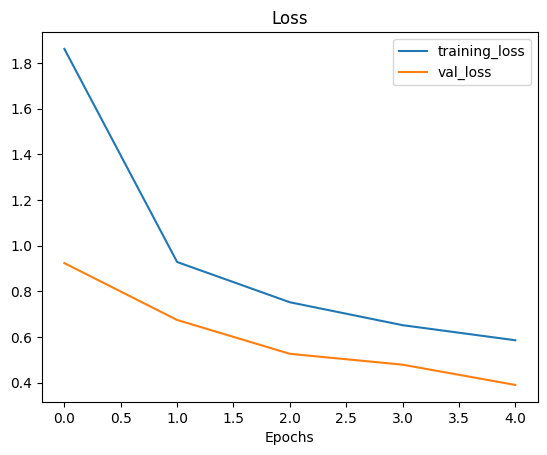

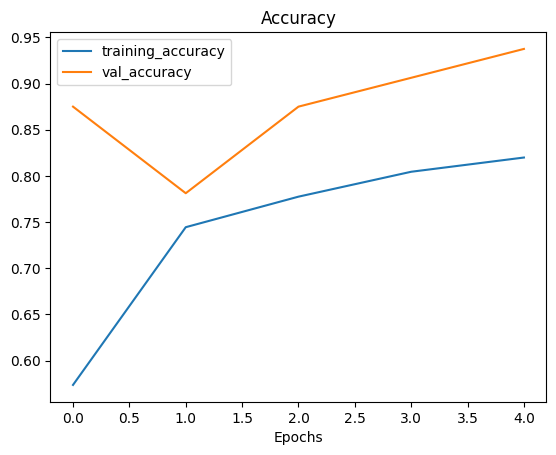

In [75]:
plot_loss_curves(base_model_history_b6)

In [76]:
model_b6.save("model/base_model_b6.h5")

## EfficientNetB7

In [77]:
# Setup the base mode and freeze its layers (to extract features)
base_model_b7 = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_b7.trainable = False

# Setup model architecture with trainable top layres
inputs_b7 = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs_b7) 
x = base_model_b7(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs_b7 = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model_b7 = tf.keras.Model(inputs_b7, outputs_b7)

In [78]:
# Compile the model
model_b7.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])


In [79]:
model_b7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_avg_pool_layer (Glob  (None, 2560)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 36)                92196     
                                                                 
Total params: 64,189,883
Trainable params: 92,196
Non-train

In [80]:
base_model_history_b7 = model_b7.fit(train_data,
                epochs=5,
                validation_data=validation_data,
                validation_steps=int(0.15*len(validation_data)),
                callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",
                experiment_name="base_model_history_b7")])

Saving TensorBoard log files to: transfer_learning/base_model_history_b7/20230406-140711
Epoch 1/5


2023-04-06 14:07:22.522297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:07:22.624590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:07:22.831448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:07:23.808595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:07:23.965995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 1:18 - loss: 3.5949 - accuracy: 0.0859

2023-04-06 14:07:28.047422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 1:13 - loss: 3.4094 - accuracy: 0.1836

2023-04-06 14:07:31.066726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:07:31.213404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 1:05 - loss: 3.2568 - accuracy: 0.2266

2023-04-06 14:07:33.793084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 1:04 - loss: 3.1838 - accuracy: 0.2433

2023-04-06 14:07:35.335918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 1:02 - loss: 3.0663 - accuracy: 0.2794

2023-04-06 14:07:37.686476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 47s - loss: 2.6491 - accuracy: 0.3844

2023-04-06 14:07:45.489271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 46s - loss: 2.5917 - accuracy: 0.3975

2023-04-06 14:07:47.156345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 43s - loss: 2.5293 - accuracy: 0.4134

2023-04-06 14:07:49.152282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 34s - loss: 2.2269 - accuracy: 0.4904

2023-04-06 14:07:59.077805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 32s - loss: 2.1805 - accuracy: 0.4964

2023-04-06 14:08:00.914938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:00.915122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 28s - loss: 2.1124 - accuracy: 0.5132

2023-04-06 14:08:03.912943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:03.942013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 26s - loss: 2.0783 - accuracy: 0.5177

2023-04-06 14:08:06.099201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:06.101356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 23s - loss: 2.0243 - accuracy: 0.5317

2023-04-06 14:08:08.146212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 22s - loss: 2.0173 - accuracy: 0.5332

2023-04-06 14:08:08.547191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 80s 690ms/step - loss: 1.7106 - accuracy: 0.5952 - val_loss: 1.0155 - val_accuracy: 0.7812
Epoch 2/5


2023-04-06 14:08:32.387217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:32.487246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:32.696831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:33.682517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:33.847722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 50s - loss: 1.0808 - accuracy: 0.6641

2023-04-06 14:08:36.576206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 51s - loss: 0.9623 - accuracy: 0.7188

2023-04-06 14:08:38.787832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:08:38.954827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 48s - loss: 0.9234 - accuracy: 0.7370

2023-04-06 14:08:41.042824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 49s - loss: 0.9284 - accuracy: 0.7411

2023-04-06 14:08:42.496004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 47s - loss: 0.9233 - accuracy: 0.7371

2023-04-06 14:08:44.273864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 39s - loss: 0.9275 - accuracy: 0.7396

2023-04-06 14:08:51.485460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 37s - loss: 0.9305 - accuracy: 0.7402

2023-04-06 14:08:52.623685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 36s - loss: 0.9086 - accuracy: 0.7473

2023-04-06 14:08:54.291631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


48/98 [=============>................] - ETA: 28s - loss: 0.8981 - accuracy: 0.7480

2023-04-06 14:09:01.692866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


51/98 [==============>...............] - ETA: 26s - loss: 0.8905 - accuracy: 0.7482

2023-04-06 14:09:03.260190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:03.261002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


56/98 [================>.............] - ETA: 23s - loss: 0.8784 - accuracy: 0.7550

2023-04-06 14:09:05.933928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:05.962349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


59/98 [=================>............] - ETA: 21s - loss: 0.8844 - accuracy: 0.7532

2023-04-06 14:09:07.599244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:07.599662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/98 [==================>...........] - ETA: 19s - loss: 0.8750 - accuracy: 0.7564

2023-04-06 14:09:09.986547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 19s - loss: 0.8707 - accuracy: 0.7588

2023-04-06 14:09:10.706687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 59s 578ms/step - loss: 0.8337 - accuracy: 0.7637 - val_loss: 0.7493 - val_accuracy: 0.8125
Epoch 3/5


2023-04-06 14:09:30.891037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:30.983102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:31.193843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:32.194006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:32.369739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 55s - loss: 0.6499 - accuracy: 0.8203

2023-04-06 14:09:35.184140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 51s - loss: 0.6883 - accuracy: 0.8047

2023-04-06 14:09:37.187696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:09:37.345143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 48s - loss: 0.6948 - accuracy: 0.7943

2023-04-06 14:09:39.340423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 48s - loss: 0.6953 - accuracy: 0.7924

2023-04-06 14:09:40.650928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 44s - loss: 0.7035 - accuracy: 0.7904

2023-04-06 14:09:42.053844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 36s - loss: 0.7260 - accuracy: 0.7792

2023-04-06 14:09:48.744815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 35s - loss: 0.7094 - accuracy: 0.7861

2023-04-06 14:09:50.017473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 34s - loss: 0.6906 - accuracy: 0.7920

2023-04-06 14:09:51.824590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 25s - loss: 0.6916 - accuracy: 0.7902

2023-04-06 14:09:58.603302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 24s - loss: 0.6858 - accuracy: 0.7903

2023-04-06 14:10:00.206471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:00.208015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 21s - loss: 0.6958 - accuracy: 0.7878

2023-04-06 14:10:02.943865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:02.985365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 20s - loss: 0.6967 - accuracy: 0.7880

2023-04-06 14:10:05.019190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:05.019963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 18s - loss: 0.6889 - accuracy: 0.7910

2023-04-06 14:10:06.814133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 17s - loss: 0.6905 - accuracy: 0.7918

2023-04-06 14:10:07.380617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 54s 536ms/step - loss: 0.6749 - accuracy: 0.7936 - val_loss: 0.6634 - val_accuracy: 0.8125
Epoch 4/5


2023-04-06 14:10:25.265725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:25.357531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:25.578780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:26.579856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:26.738500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 50s - loss: 0.5194 - accuracy: 0.8438

2023-04-06 14:10:29.250510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 47s - loss: 0.6079 - accuracy: 0.8203

2023-04-06 14:10:31.123765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:31.277624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 45s - loss: 0.5948 - accuracy: 0.8229

2023-04-06 14:10:33.283217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 45s - loss: 0.5942 - accuracy: 0.8214

2023-04-06 14:10:34.482058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 45s - loss: 0.5915 - accuracy: 0.8199

2023-04-06 14:10:36.406686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 36s - loss: 0.6049 - accuracy: 0.8167

2023-04-06 14:10:43.148157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 36s - loss: 0.6075 - accuracy: 0.8135

2023-04-06 14:10:44.402507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 33s - loss: 0.6055 - accuracy: 0.8161

2023-04-06 14:10:45.568928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 25s - loss: 0.6167 - accuracy: 0.8157

2023-04-06 14:10:52.122859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 23s - loss: 0.6164 - accuracy: 0.8167

2023-04-06 14:10:53.211932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:53.212695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 20s - loss: 0.6111 - accuracy: 0.8196

2023-04-06 14:10:55.772194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:55.810964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 19s - loss: 0.6079 - accuracy: 0.8203

2023-04-06 14:10:57.497467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:10:57.497883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 17s - loss: 0.6043 - accuracy: 0.8193

2023-04-06 14:10:59.514898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 16s - loss: 0.6019 - accuracy: 0.8191

2023-04-06 14:11:00.188134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 53s 519ms/step - loss: 0.5895 - accuracy: 0.8225 - val_loss: 0.6360 - val_accuracy: 0.7500
Epoch 5/5


2023-04-06 14:11:17.881184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:17.989506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:18.210096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:19.253581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:19.424818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/98 [>.............................] - ETA: 39s - loss: 0.4721 - accuracy: 0.8687

2023-04-06 14:11:21.525152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 38s - loss: 0.4997 - accuracy: 0.8516

2023-04-06 14:11:22.968485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:23.121507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 37s - loss: 0.4935 - accuracy: 0.8490

2023-04-06 14:11:24.757011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


14/98 [===>..........................] - ETA: 37s - loss: 0.4968 - accuracy: 0.8438

2023-04-06 14:11:25.752537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


17/98 [====>.........................] - ETA: 33s - loss: 0.5246 - accuracy: 0.8309

2023-04-06 14:11:26.603930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 32s - loss: 0.5391 - accuracy: 0.8260

2023-04-06 14:11:33.713297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/98 [========>.....................] - ETA: 31s - loss: 0.5499 - accuracy: 0.8203

2023-04-06 14:11:34.694774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


35/98 [=========>....................] - ETA: 29s - loss: 0.5469 - accuracy: 0.8214

2023-04-06 14:11:35.873460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/98 [==============>...............] - ETA: 23s - loss: 0.5378 - accuracy: 0.8265

2023-04-06 14:11:42.779854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


52/98 [==============>...............] - ETA: 22s - loss: 0.5398 - accuracy: 0.8251

2023-04-06 14:11:44.447723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:44.449446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


57/98 [================>.............] - ETA: 20s - loss: 0.5327 - accuracy: 0.8279

2023-04-06 14:11:47.347459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:47.379918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 18s - loss: 0.5365 - accuracy: 0.8266

2023-04-06 14:11:49.040368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:11:49.041019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 16s - loss: 0.5251 - accuracy: 0.8296

2023-04-06 14:11:51.021557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


65/98 [==================>...........] - ETA: 16s - loss: 0.5265 - accuracy: 0.8293

2023-04-06 14:11:51.675760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 51s 502ms/step - loss: 0.5139 - accuracy: 0.8360 - val_loss: 0.5824 - val_accuracy: 0.8125


In [81]:
# Evaluate on whole test dataset
feature_extraction_results_b7 = model_b7.evaluate(test_data)
feature_extraction_results_b7

 4/12 [=========>....................] - ETA: 2s - loss: 0.4800 - accuracy: 0.8125

2023-04-06 14:12:10.069950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/12 [==============>...............] - ETA: 1s - loss: 0.4012 - accuracy: 0.8594

2023-04-06 14:12:10.633768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 4s 312ms/step - loss: 0.3434 - accuracy: 0.8858


[0.3434199094772339, 0.8857938647270203]

In [82]:
print('The accuracy of the base model is ',feature_extraction_results_b7[1])

The accuracy of the base model is  0.8857938647270203


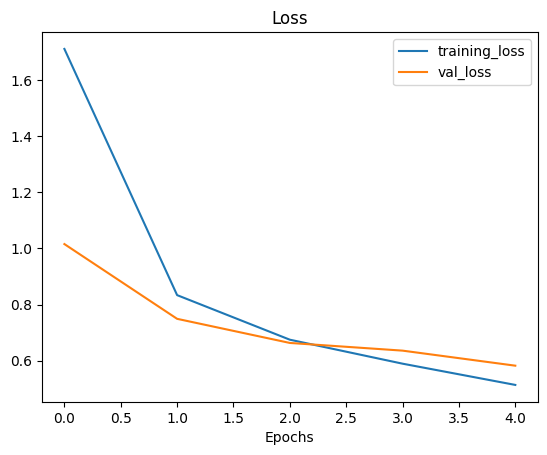

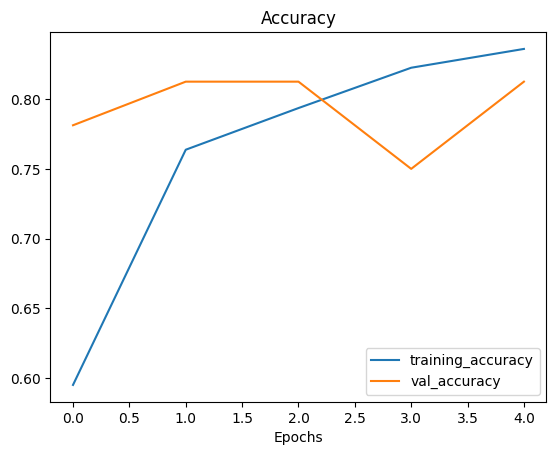

In [83]:
plot_loss_curves(base_model_history_b7)

In [84]:
model_b7.save("model/base_model_b7.h5")

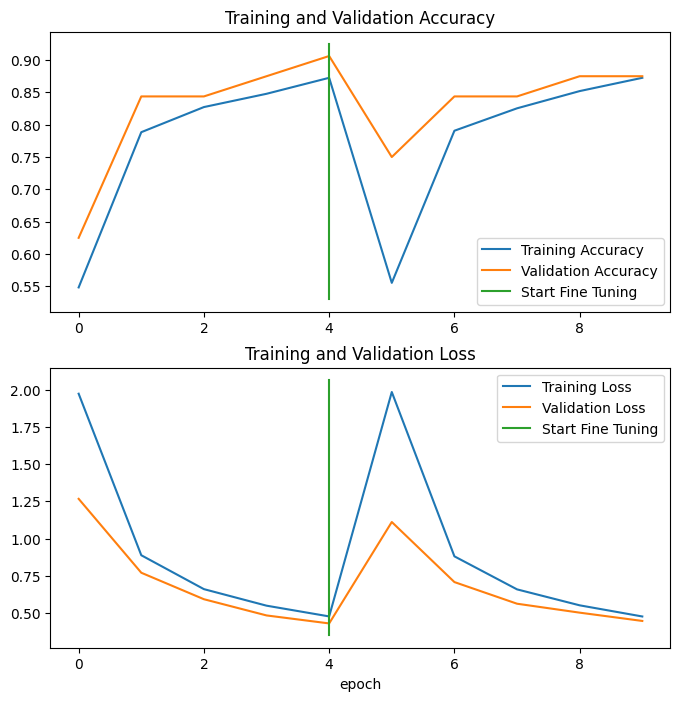

In [85]:
# Compare the histories with fine tuning
compare_historys(original_history=base_model_history_b0,
                new_history=base_model_history_b1,
                initial_epochs=5)

#### Making Predictionas with our model

In [86]:
feature_extraction_results_b0, feature_extraction_results_b1, feature_extraction_results_b2, feature_extraction_results_b3, feature_extraction_results_b4, feature_extraction_results_b5, feature_extraction_results_b6, feature_extraction_results_b7

([0.2953711748123169, 0.9164345264434814],
 [0.33268651366233826, 0.9052924513816833],
 [0.33911755681037903, 0.8746517896652222],
 [0.31882235407829285, 0.9080780148506165],
 [0.3621941804885864, 0.8885793685913086],
 [0.33549928665161133, 0.8774373531341553],
 [0.3569667935371399, 0.8830083608627319],
 [0.3434199094772339, 0.8857938647270203])

In [87]:
# Make predictions with model
preds_probs_b0 =  model_b0.predict(test_data, verbose=1) # set verbosity to see how log is left
preds_probs_b1 =  model_b1.predict(test_data, verbose=1) 
preds_probs_b2 =  model_b2.predict(test_data, verbose=1) 
preds_probs_b3 =  model_b3.predict(test_data, verbose=1) 
preds_probs_b4 =  model_b4.predict(test_data, verbose=1) 
preds_probs_b5 =  model_b5.predict(test_data, verbose=1) 
preds_probs_b6 =  model_b6.predict(test_data, verbose=1) 
preds_probs_b7 =  model_b7.predict(test_data, verbose=1) 

 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:15.678403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s

2023-04-06 14:12:16.025864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:18.611817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s

2023-04-06 14:12:18.939364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:21.678033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s

2023-04-06 14:12:22.005792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:24.799446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s

2023-04-06 14:12:25.143212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:28.271068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 0s

2023-04-06 14:12:28.606427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:32.409903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s

2023-04-06 14:12:32.751399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 1s

2023-04-06 14:12:37.189273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s

2023-04-06 14:12:37.594835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/12 [===========>..................] - ETA: 2s

2023-04-06 14:12:43.018040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/12 [================>.............] - ETA: 1s

2023-04-06 14:12:43.606747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 6s 283ms/step


## as EfficientNetB5's accuracy is higher, we take it for the visualization

In [88]:
len(preds_probs_b5)

359

In [89]:
preds_probs_b5.shape

(359, 36)

In [90]:
preds_probs_b5[:10]

array([[8.69273543e-01, 6.43205654e-04, 1.16608769e-03, 4.89921076e-04,
        7.65108707e-05, 1.13463704e-03, 2.19626134e-04, 9.46311629e-05,
        8.24845862e-04, 1.07691405e-04, 7.48193779e-05, 1.57889051e-04,
        1.36025425e-04, 4.59745424e-05, 1.73643092e-03, 2.10474449e-04,
        1.54616088e-02, 6.51882961e-04, 3.10570496e-04, 1.75636597e-02,
        1.22014130e-03, 2.40932941e-03, 6.28337613e-04, 6.35430887e-02,
        5.74348436e-04, 1.93956788e-04, 2.84816627e-03, 1.25631934e-03,
        1.09377806e-03, 6.99996948e-04, 1.23288555e-04, 4.96257817e-05,
        3.16914986e-04, 1.11268433e-02, 2.10793875e-03, 1.42790924e-03],
       [8.69273543e-01, 6.43205654e-04, 1.16608769e-03, 4.89921076e-04,
        7.65108707e-05, 1.13463704e-03, 2.19626134e-04, 9.46311629e-05,
        8.24845862e-04, 1.07691405e-04, 7.48193779e-05, 1.57889051e-04,
        1.36025425e-04, 4.59745424e-05, 1.73643092e-03, 2.10474449e-04,
        1.54616088e-02, 6.51882961e-04, 3.10570496e-04, 1.75636

In [91]:
preds_probs_b5[0], max(preds_probs_b5[0]), sum(preds_probs_b5[0])

(array([8.69273543e-01, 6.43205654e-04, 1.16608769e-03, 4.89921076e-04,
        7.65108707e-05, 1.13463704e-03, 2.19626134e-04, 9.46311629e-05,
        8.24845862e-04, 1.07691405e-04, 7.48193779e-05, 1.57889051e-04,
        1.36025425e-04, 4.59745424e-05, 1.73643092e-03, 2.10474449e-04,
        1.54616088e-02, 6.51882961e-04, 3.10570496e-04, 1.75636597e-02,
        1.22014130e-03, 2.40932941e-03, 6.28337613e-04, 6.35430887e-02,
        5.74348436e-04, 1.93956788e-04, 2.84816627e-03, 1.25631934e-03,
        1.09377806e-03, 6.99996948e-04, 1.23288555e-04, 4.96257817e-05,
        3.16914986e-04, 1.11268433e-02, 2.10793875e-03, 1.42790924e-03],
       dtype=float32),
 0.86927354,
 1.0000000194522727)

In [92]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs_b5[0])}")
print(f"Waht prediction probability sample 0 looks like:\n {preds_probs_b5[0]}")
print(f"The class with the heighest predicted probability by the model for sample 0: {preds_probs_b5[0].argmax()}")

Number of prediction probabilities for sample 0: 36
Waht prediction probability sample 0 looks like:
 [8.69273543e-01 6.43205654e-04 1.16608769e-03 4.89921076e-04
 7.65108707e-05 1.13463704e-03 2.19626134e-04 9.46311629e-05
 8.24845862e-04 1.07691405e-04 7.48193779e-05 1.57889051e-04
 1.36025425e-04 4.59745424e-05 1.73643092e-03 2.10474449e-04
 1.54616088e-02 6.51882961e-04 3.10570496e-04 1.75636597e-02
 1.22014130e-03 2.40932941e-03 6.28337613e-04 6.35430887e-02
 5.74348436e-04 1.93956788e-04 2.84816627e-03 1.25631934e-03
 1.09377806e-03 6.99996948e-04 1.23288555e-04 4.96257817e-05
 3.16914986e-04 1.11268433e-02 2.10793875e-03 1.42790924e-03]
The class with the heighest predicted probability by the model for sample 0: 0


In [93]:
pred_classes_b5 = preds_probs_b5.argmax(axis=1)

pred_classes_b5[:10]

array([ 0,  0,  0,  0,  0,  0,  0,  0, 33,  0])

In [94]:
len(pred_classes_b5)

359

In [95]:
y_label = []
for images, labels in test_data.unbatch():
    y_label.append(labels.numpy().argmax()) 
    
y_label[:10]

2023-04-06 14:12:45.939898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-06 14:12:46.263940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [96]:
len(y_label)

359

#### Evaluating Model's Predictions

In [97]:
from sklearn.metrics import accuracy_score
sklearn_accuracy_b5 = accuracy_score(y_true=y_label, y_pred=pred_classes_b5)
sklearn_accuracy_b5

0.8774373259052924

In [98]:
make_confusion_matrix(y_true=y_label, y_pred=pred_classes_b5, classes=test_data.class_names, figsize=(100, 100))

### Classification Report

In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_label, y_pred=pred_classes_b5))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.78      0.88         9
           2       0.91      1.00      0.95        10
           3       0.35      0.60      0.44        10
           4       1.00      1.00      1.00        10
           5       0.12      0.10      0.11        10
           6       0.91      1.00      0.95        10
           7       0.91      1.00      0.95        10
           8       0.78      0.70      0.74        10
           9       1.00      0.10      0.18        10
          10       0.91      1.00      0.95        10
          11       0.89      0.80      0.84        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      0.80      0.89        10
          15       0.75      0.90      0.82        10
          16       1.00      1.00      1.00        10
          17       1.00    

In [100]:
classification_report_dict_b5 = classification_report(y_true=y_label, y_pred=pred_classes_b5, output_dict=True)

In [101]:
class_names = test_data.class_names

In [102]:
class_precision_scores_b5 = {}


for k, v in classification_report_dict_b5.items():
    if k == "accuracy": 
        break
    else:
        
        class_precision_scores_b5[class_names[int(k)]] = v["precision"]
class_precision_scores_b5

{'apple': 1.0,
 'banana': 1.0,
 'beetroot': 0.9090909090909091,
 'bell pepper': 0.35294117647058826,
 'cabbage': 1.0,
 'capsicum': 0.125,
 'carrot': 0.9090909090909091,
 'cauliflower': 0.9090909090909091,
 'chilli pepper': 0.7777777777777778,
 'corn': 1.0,
 'cucumber': 0.9090909090909091,
 'eggplant': 0.8888888888888888,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 1.0,
 'jalepeno': 0.75,
 'kiwi': 1.0,
 'lemon': 1.0,
 'lettuce': 1.0,
 'mango': 0.9,
 'onion': 1.0,
 'orange': 0.9090909090909091,
 'paprika': 1.0,
 'pear': 0.9090909090909091,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 1.0,
 'raddish': 0.9090909090909091,
 'soy beans': 0.9090909090909091,
 'spinach': 1.0,
 'sweetcorn': 0.5263157894736842,
 'sweetpotato': 1.0,
 'tomato': 0.8333333333333334,
 'turnip': 1.0,
 'watermelon': 1.0}

In [103]:
import pandas as pd

precision_scores_b5 = pd.DataFrame({"class_names": list(class_precision_scores_b5.keys()),
                         "precision": list(class_precision_scores_b5.values())}).sort_values("precision", ascending=False)

In [104]:
precision_scores_b5[:10]

class_names  precision
0         apple        1.0
14       grapes        1.0
34       turnip        1.0
32  sweetpotato        1.0
30      spinach        1.0
27       potato        1.0
26  pomegranate        1.0
25    pineapple        1.0
24         peas        1.0
22      paprika        1.0

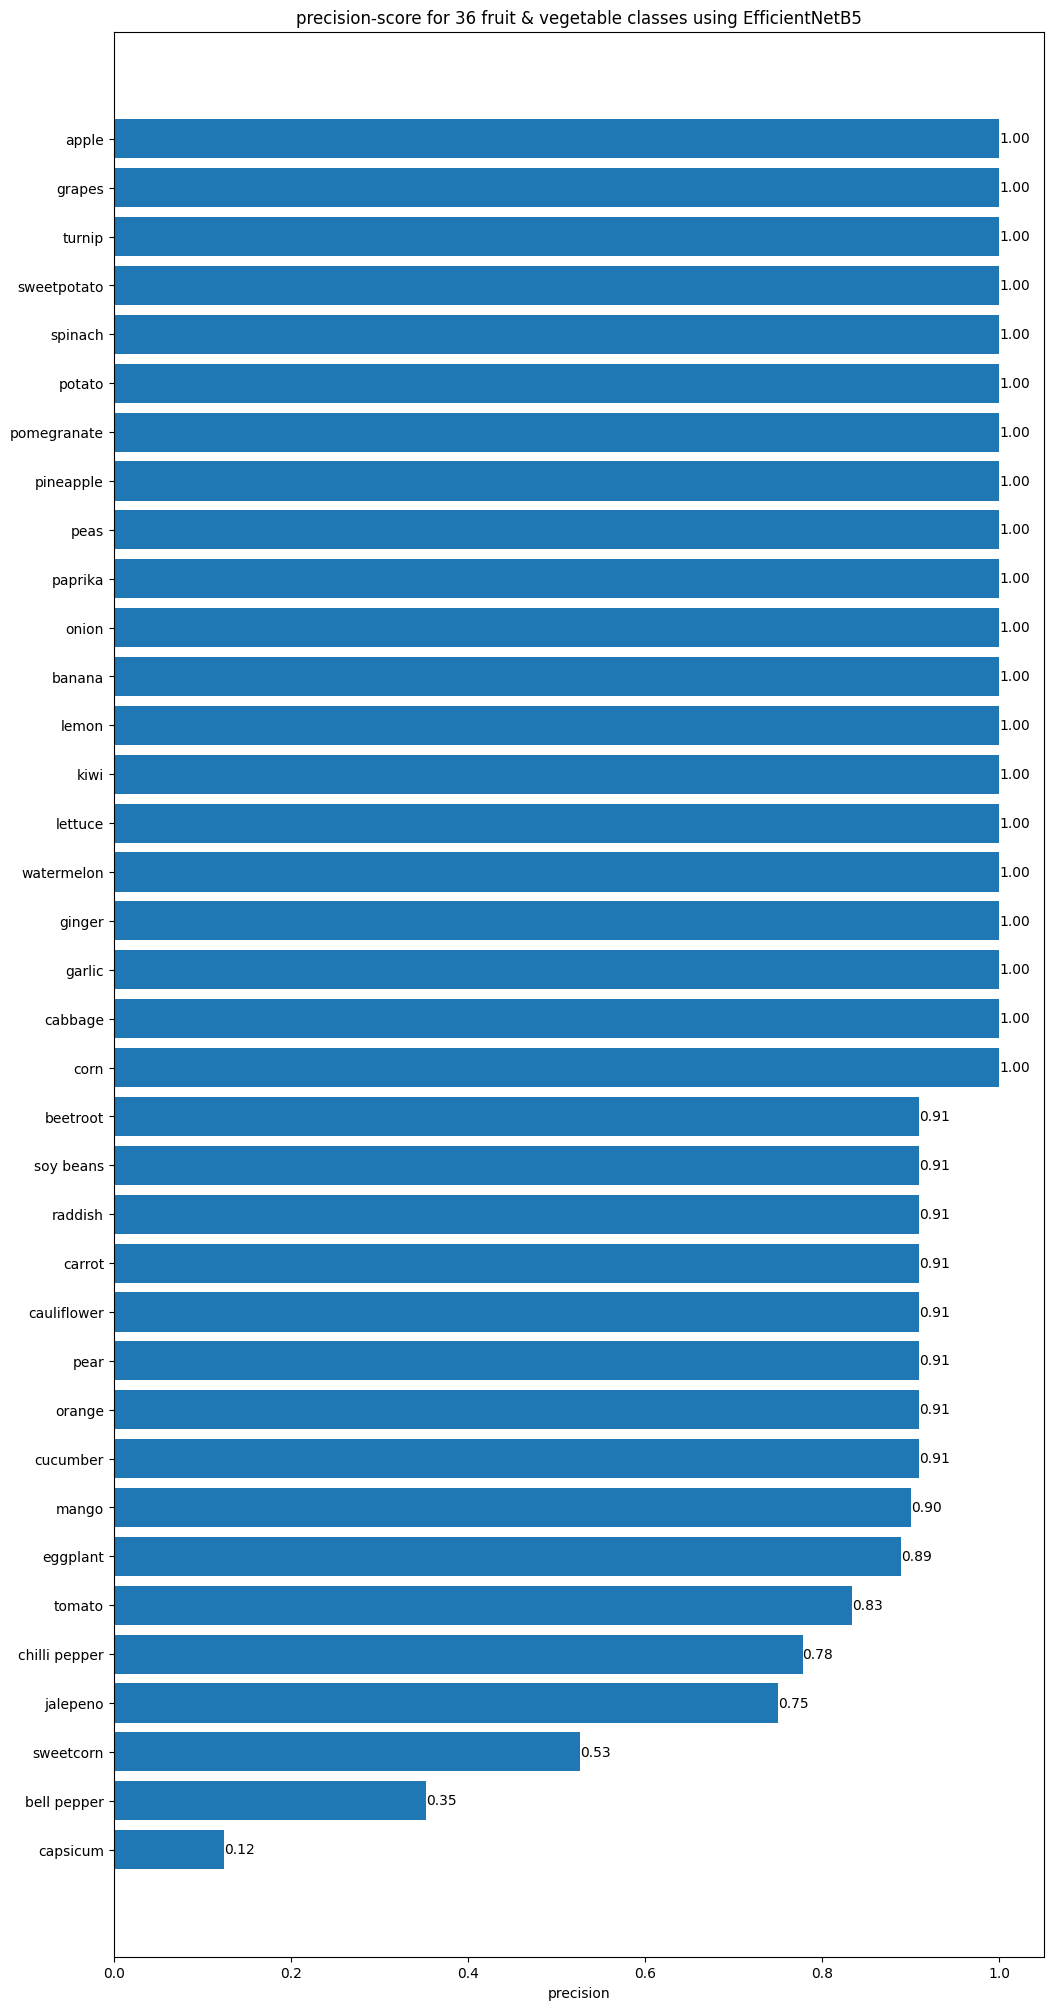

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(precision_scores_b5)), precision_scores_b5["precision"].values)
ax.set_yticks(range(len(precision_scores_b5)))
ax.set_yticklabels(precision_scores_b5["class_names"])
ax.set_xlabel("precision")
ax.set_title("precision-score for 36 fruit & vegetable classes using EfficientNetB5")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

In [106]:
class_recall_scores_b5 = {}

for k, v in classification_report_dict_b5.items():
    if k == "accuracy": 
        break
    else:
        class_recall_scores_b5[class_names[int(k)]] = v["recall"]
class_recall_scores_b5

{'apple': 0.9,
 'banana': 0.7777777777777778,
 'beetroot': 1.0,
 'bell pepper': 0.6,
 'cabbage': 1.0,
 'capsicum': 0.1,
 'carrot': 1.0,
 'cauliflower': 1.0,
 'chilli pepper': 0.7,
 'corn': 0.1,
 'cucumber': 1.0,
 'eggplant': 0.8,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 0.8,
 'jalepeno': 0.9,
 'kiwi': 1.0,
 'lemon': 0.9,
 'lettuce': 1.0,
 'mango': 0.9,
 'onion': 1.0,
 'orange': 1.0,
 'paprika': 0.5,
 'pear': 1.0,
 'peas': 0.9,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 0.7,
 'raddish': 1.0,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 1.0,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [107]:
import pandas as pd

recall_scores_b5 = pd.DataFrame({"class_names": list(class_recall_scores_b5.keys()),
                         "recall": list(class_recall_scores_b5.values())}).sort_values("recall", ascending=False)

In [108]:
recall_scores_b5[:10]

class_names  recall
18      lettuce     1.0
16         kiwi     1.0
34       turnip     1.0
33       tomato     1.0
32  sweetpotato     1.0
31    sweetcorn     1.0
30      spinach     1.0
29    soy beans     1.0
28      raddish     1.0
26  pomegranate     1.0

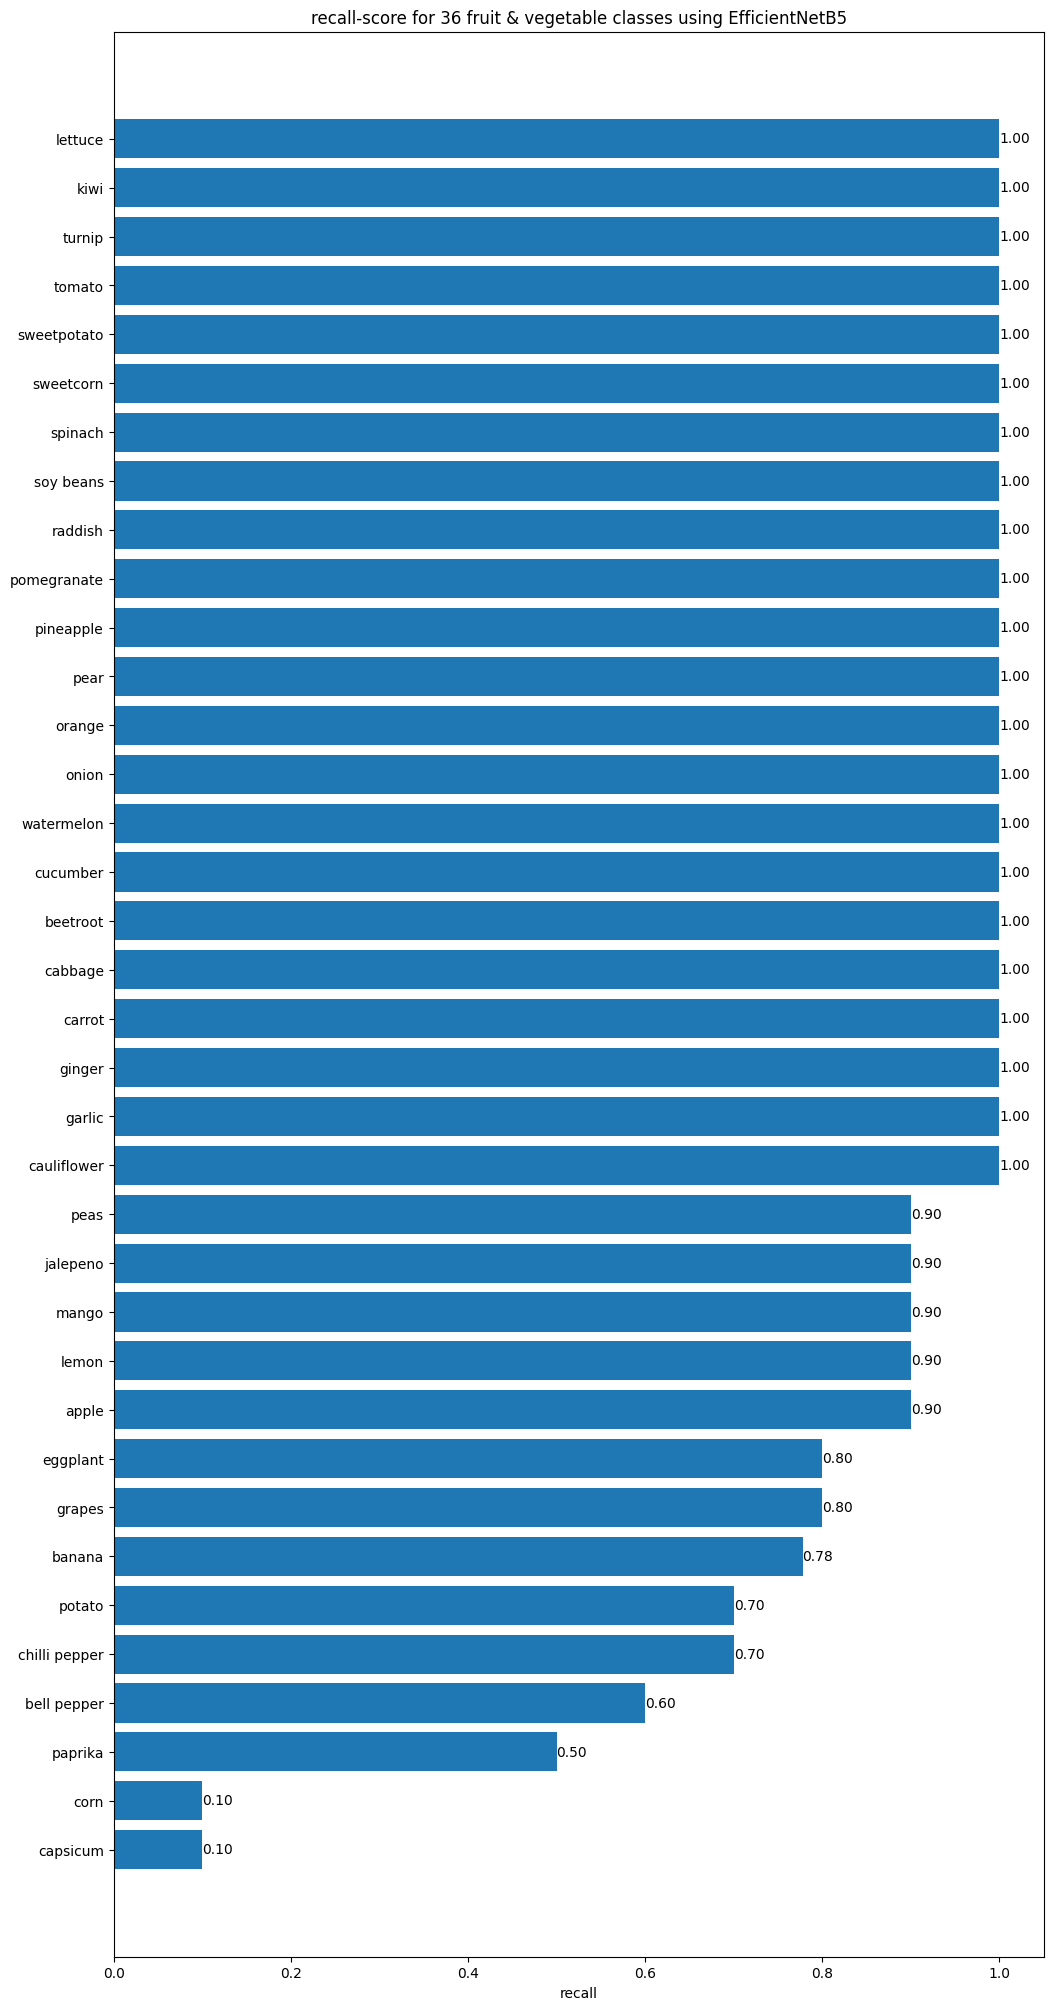

In [109]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(recall_scores_b5)), recall_scores_b5["recall"].values)
ax.set_yticks(range(len(recall_scores_b5)))
ax.set_yticklabels(recall_scores_b5["class_names"])
ax.set_xlabel("recall")
ax.set_title("recall-score for 36 fruit & vegetable classes using EfficientNetB5")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

In [110]:
class_f1_scores_b5 = {}

for k, v in classification_report_dict_b5.items():
    if k == "accuracy": 
        break
    else:
        class_f1_scores_b5[class_names[int(k)]] = v["f1-score"]
class_f1_scores_b5

{'apple': 0.9473684210526316,
 'banana': 0.8750000000000001,
 'beetroot': 0.9523809523809523,
 'bell pepper': 0.4444444444444445,
 'cabbage': 1.0,
 'capsicum': 0.11111111111111112,
 'carrot': 0.9523809523809523,
 'cauliflower': 0.9523809523809523,
 'chilli pepper': 0.7368421052631577,
 'corn': 0.18181818181818182,
 'cucumber': 0.9523809523809523,
 'eggplant': 0.8421052631578948,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 0.888888888888889,
 'jalepeno': 0.8181818181818182,
 'kiwi': 1.0,
 'lemon': 0.9473684210526316,
 'lettuce': 1.0,
 'mango': 0.9,
 'onion': 1.0,
 'orange': 0.9523809523809523,
 'paprika': 0.6666666666666666,
 'pear': 0.9523809523809523,
 'peas': 0.9473684210526316,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 0.8235294117647058,
 'raddish': 0.9523809523809523,
 'soy beans': 0.9523809523809523,
 'spinach': 1.0,
 'sweetcorn': 0.6896551724137931,
 'sweetpotato': 1.0,
 'tomato': 0.9090909090909091,
 'turnip': 1.0,
 'watermelon': 1.0}

In [111]:
import pandas as pd

f1_scores_b5 = pd.DataFrame({"class_names": list(class_f1_scores_b5.keys()),
                         "f1-score": list(class_f1_scores_b5.values())}).sort_values("f1-score", ascending=False)

In [112]:
f1_scores_b5[:10]

class_names  f1-score
18      lettuce       1.0
12       garlic       1.0
34       turnip       1.0
32  sweetpotato       1.0
30      spinach       1.0
26  pomegranate       1.0
25    pineapple       1.0
20        onion       1.0
16         kiwi       1.0
13       ginger       1.0

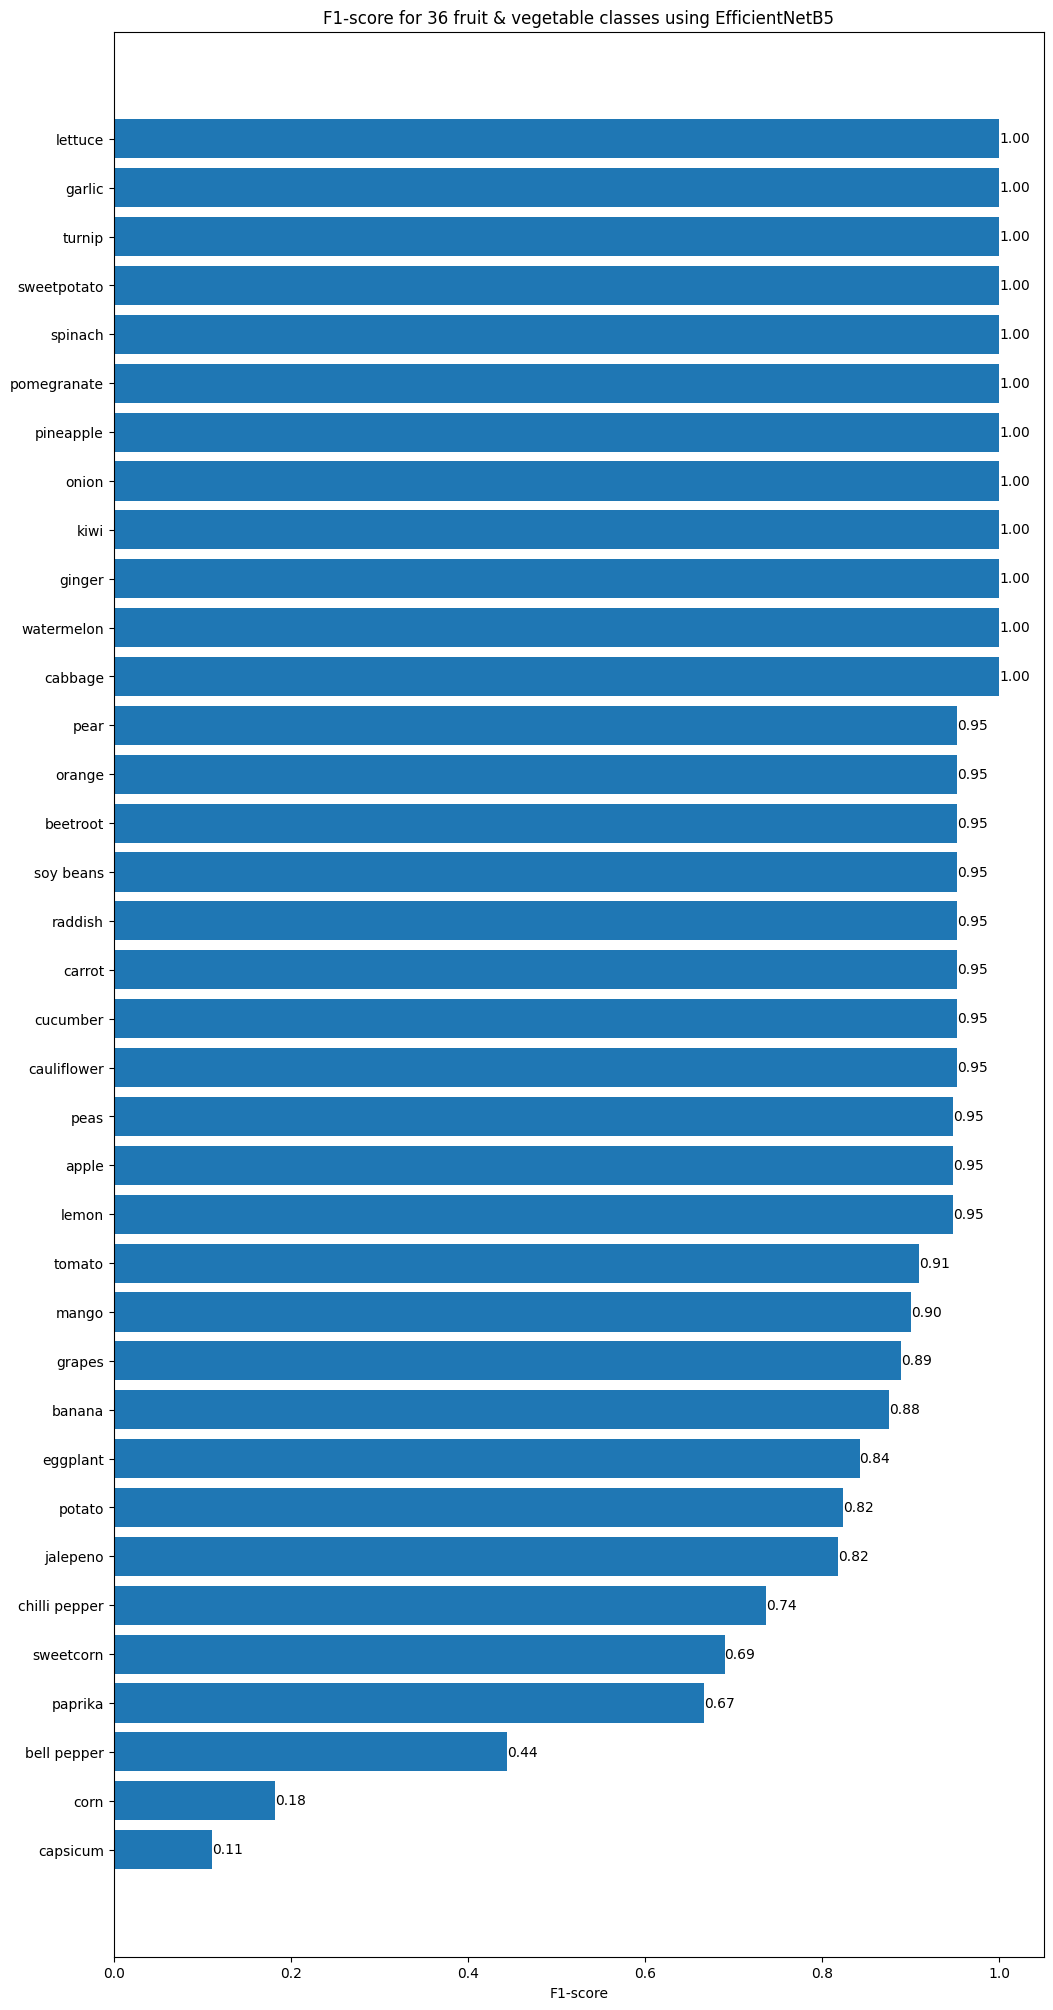

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores_b5)), f1_scores_b5["f1-score"].values)
ax.set_yticks(range(len(f1_scores_b5)))
ax.set_yticklabels(f1_scores_b5["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 36 fruit & vegetable classes using EfficientNetB5")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

#### Visualizing predictions on test images

1/1 [==============================] - 0s 41ms/step


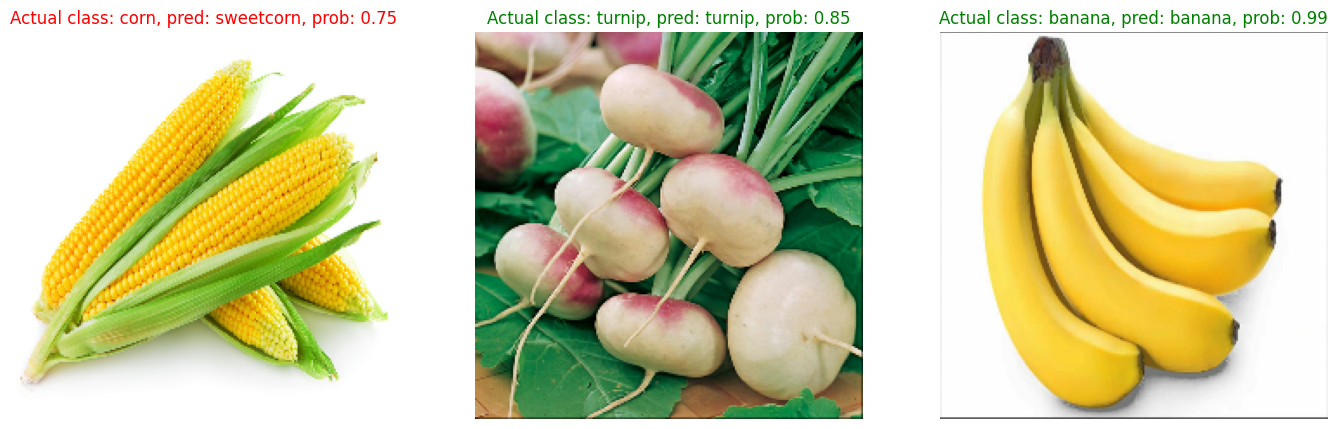

In [114]:
# visualize test images

# Make preds on series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename
    
    # Load the images and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model_b5.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()] 
    
    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual class: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);
    

## EfficientNetB0's visualization

In [115]:
len(preds_probs_b0)

359

In [116]:
preds_probs_b0.shape

(359, 36)

In [117]:
preds_probs_b0[:10]

array([[6.37747228e-01, 4.49653162e-04, 5.89291751e-03, 1.42103119e-03,
        3.58910387e-04, 3.35508282e-03, 2.93580582e-04, 3.64902051e-04,
        3.32414941e-03, 1.93267027e-04, 4.88022226e-04, 4.76373389e-04,
        4.86905083e-05, 5.43597998e-05, 2.30928604e-03, 4.52552311e-04,
        2.55199731e-03, 1.60188787e-03, 8.62374611e-04, 1.63162611e-02,
        1.20437448e-03, 6.94335531e-03, 4.69808048e-03, 4.00426947e-02,
        3.51890718e-04, 6.35306875e-04, 2.26850271e-01, 8.42236623e-04,
        2.04197550e-03, 4.06609935e-04, 3.79020552e-04, 3.58394289e-04,
        6.91570865e-04, 2.61077061e-02, 3.07622878e-03, 6.80775382e-03],
       [6.37747228e-01, 4.49653162e-04, 5.89291751e-03, 1.42103119e-03,
        3.58910387e-04, 3.35508282e-03, 2.93580582e-04, 3.64902051e-04,
        3.32414941e-03, 1.93267027e-04, 4.88022226e-04, 4.76373389e-04,
        4.86905083e-05, 5.43597998e-05, 2.30928604e-03, 4.52552311e-04,
        2.55199731e-03, 1.60188787e-03, 8.62374611e-04, 1.63162

In [118]:
preds_probs_b0[0], max(preds_probs_b0[0]), sum(preds_probs_b0[0])

(array([6.3774723e-01, 4.4965316e-04, 5.8929175e-03, 1.4210312e-03,
        3.5891039e-04, 3.3550828e-03, 2.9358058e-04, 3.6490205e-04,
        3.3241494e-03, 1.9326703e-04, 4.8802223e-04, 4.7637339e-04,
        4.8690508e-05, 5.4359800e-05, 2.3092860e-03, 4.5255231e-04,
        2.5519973e-03, 1.6018879e-03, 8.6237461e-04, 1.6316261e-02,
        1.2043745e-03, 6.9433553e-03, 4.6980805e-03, 4.0042695e-02,
        3.5189072e-04, 6.3530687e-04, 2.2685027e-01, 8.4223662e-04,
        2.0419755e-03, 4.0660994e-04, 3.7902055e-04, 3.5839429e-04,
        6.9157087e-04, 2.6107706e-02, 3.0762288e-03, 6.8077538e-03],
       dtype=float32),
 0.6377472,
 0.9999999977335392)

In [119]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs_b0[0])}")
print(f"Waht prediction probability sample 0 looks like:\n {preds_probs_b0[0]}")
print(f"The class with the heighest predicted probability by the model for sample 0: {preds_probs_b0[0].argmax()}")

Number of prediction probabilities for sample 0: 36
Waht prediction probability sample 0 looks like:
 [6.3774723e-01 4.4965316e-04 5.8929175e-03 1.4210312e-03 3.5891039e-04
 3.3550828e-03 2.9358058e-04 3.6490205e-04 3.3241494e-03 1.9326703e-04
 4.8802223e-04 4.7637339e-04 4.8690508e-05 5.4359800e-05 2.3092860e-03
 4.5255231e-04 2.5519973e-03 1.6018879e-03 8.6237461e-04 1.6316261e-02
 1.2043745e-03 6.9433553e-03 4.6980805e-03 4.0042695e-02 3.5189072e-04
 6.3530687e-04 2.2685027e-01 8.4223662e-04 2.0419755e-03 4.0660994e-04
 3.7902055e-04 3.5839429e-04 6.9157087e-04 2.6107706e-02 3.0762288e-03
 6.8077538e-03]
The class with the heighest predicted probability by the model for sample 0: 0


In [120]:
pred_classes_b0 = preds_probs_b0.argmax(axis=1)

pred_classes_b0[:10]

array([ 0,  0,  0,  0, 23,  0,  0,  0,  0,  0])

In [121]:
len(pred_classes_b0)

359

#### Evaluating Model's Predictions

In [122]:
sklearn_accuracy = accuracy_score(y_true=y_label, y_pred=pred_classes_b0)
sklearn_accuracy

0.9164345403899722

In [123]:
make_confusion_matrix(y_true=y_label, y_pred=pred_classes_b0, classes=test_data.class_names, figsize=(100, 100))

### Classification Report

In [124]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_label, y_pred=pred_classes_b0))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       1.00      0.78      0.88         9
           2       0.91      1.00      0.95        10
           3       0.50      0.80      0.62        10
           4       1.00      1.00      1.00        10
           5       0.62      0.50      0.56        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       0.78      0.70      0.74        10
           9       1.00      0.40      0.57        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      0.90      0.95        10
          15       0.91      1.00      0.95        10
          16       1.00      1.00      1.00        10
          17       1.00    

In [125]:
classification_report_dict_b0 = classification_report(y_true=y_label, y_pred=pred_classes_b0, output_dict=True)

In [126]:
class_precision_scores_b0 = {}


for k, v in classification_report_dict_b0.items():
    if k == "accuracy": 
        break
    else:
        
        class_precision_scores_b0[class_names[int(k)]] = v["precision"]
class_precision_scores_b0

{'apple': 0.75,
 'banana': 1.0,
 'beetroot': 0.9090909090909091,
 'bell pepper': 0.5,
 'cabbage': 1.0,
 'capsicum': 0.625,
 'carrot': 1.0,
 'cauliflower': 1.0,
 'chilli pepper': 0.7777777777777778,
 'corn': 1.0,
 'cucumber': 1.0,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 1.0,
 'jalepeno': 0.9090909090909091,
 'kiwi': 1.0,
 'lemon': 1.0,
 'lettuce': 1.0,
 'mango': 0.75,
 'onion': 1.0,
 'orange': 0.9090909090909091,
 'paprika': 1.0,
 'pear': 0.8333333333333334,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 1.0,
 'raddish': 1.0,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 0.625,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [127]:
precision_scores_b0 = pd.DataFrame({"class_names": list(class_precision_scores_b0.keys()),
                         "precision": list(class_precision_scores_b0.values())}).sort_values("precision", ascending=False)

In [128]:
precision_scores_b0[:10]

class_names  precision
18      lettuce        1.0
16         kiwi        1.0
34       turnip        1.0
33       tomato        1.0
32  sweetpotato        1.0
30      spinach        1.0
29    soy beans        1.0
28      raddish        1.0
27       potato        1.0
26  pomegranate        1.0

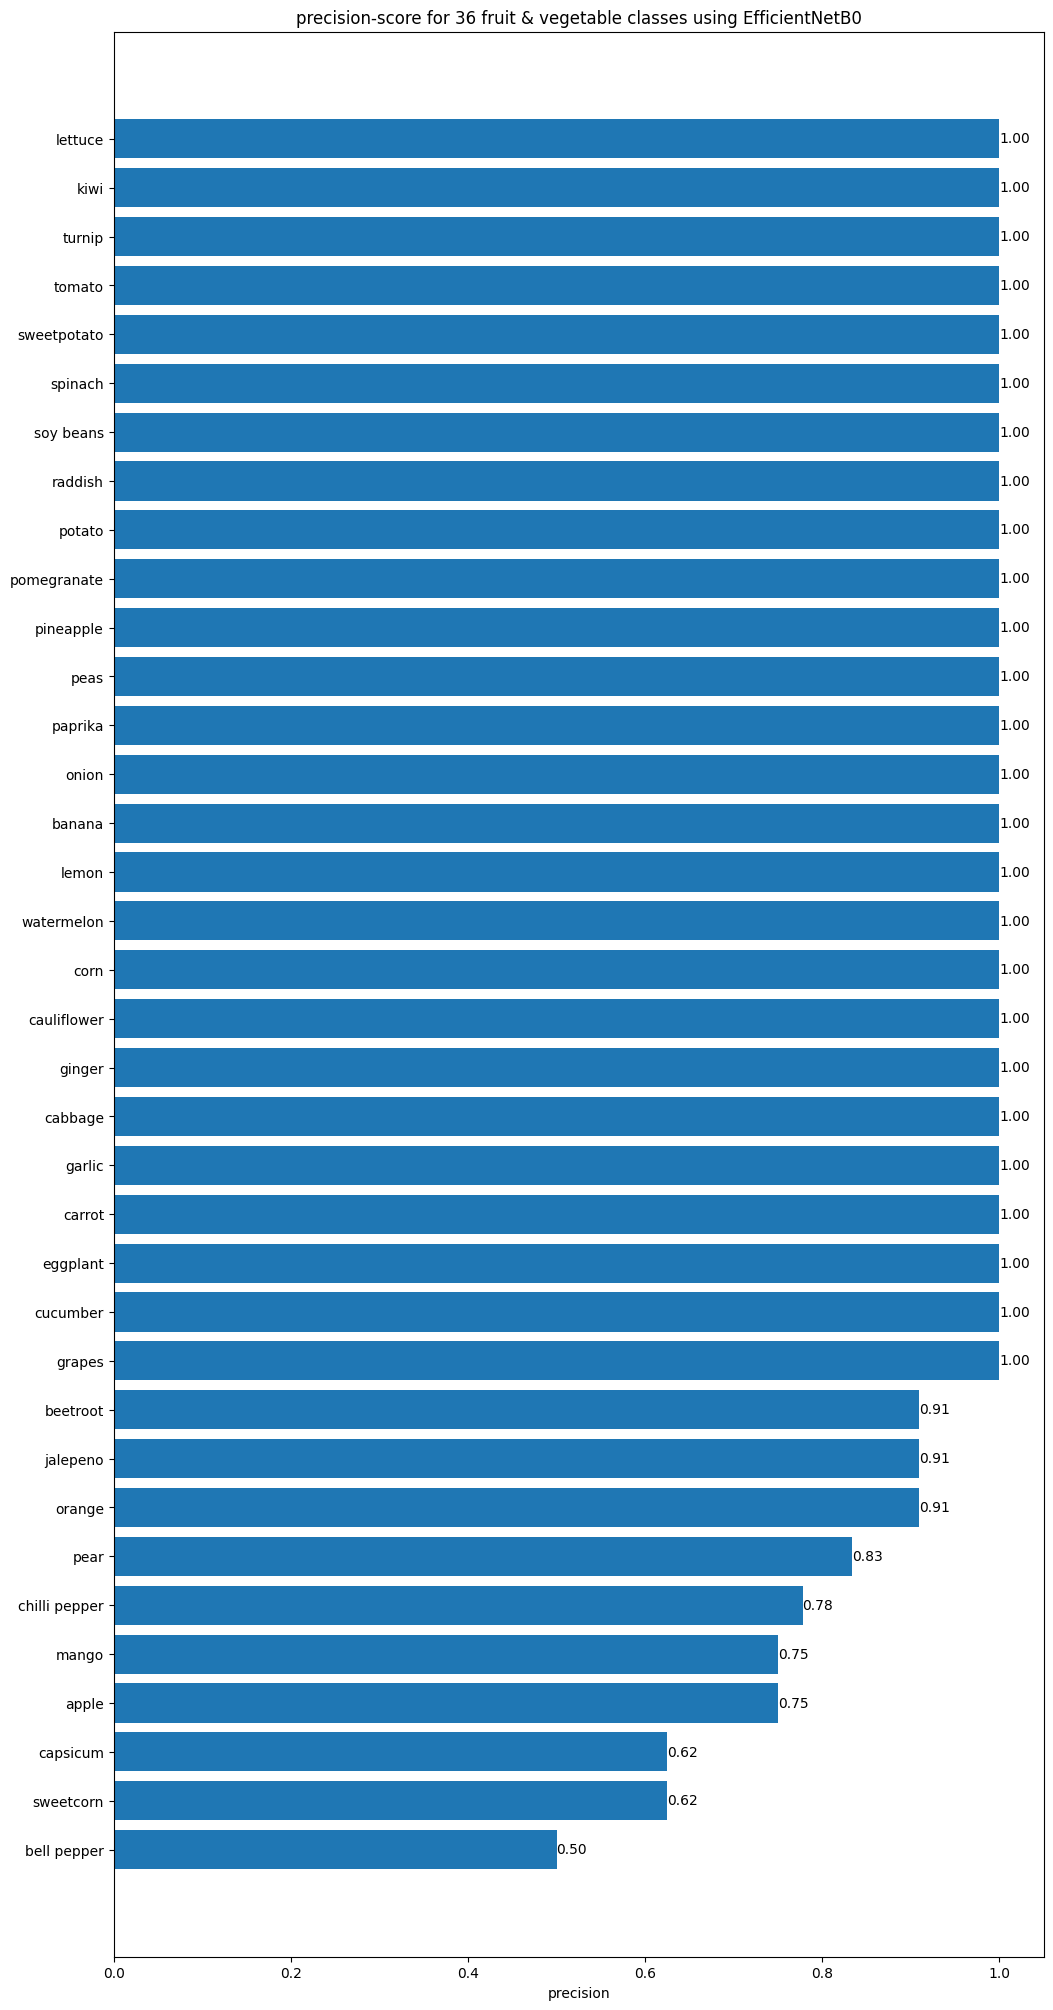

In [129]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(precision_scores_b0)), precision_scores_b0["precision"].values)
ax.set_yticks(range(len(precision_scores_b0)))
ax.set_yticklabels(precision_scores_b0["class_names"])
ax.set_xlabel("precision")
ax.set_title("precision-score for 36 fruit & vegetable classes using EfficientNetB0")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

In [130]:
class_recall_scores_b0 = {}

for k, v in classification_report_dict_b0.items():
    if k == "accuracy": 
        break
    else:
        class_recall_scores_b0[class_names[int(k)]] = v["recall"]
class_recall_scores_b0

{'apple': 0.9,
 'banana': 0.7777777777777778,
 'beetroot': 1.0,
 'bell pepper': 0.8,
 'cabbage': 1.0,
 'capsicum': 0.5,
 'carrot': 1.0,
 'cauliflower': 1.0,
 'chilli pepper': 0.7,
 'corn': 0.4,
 'cucumber': 1.0,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 0.9,
 'jalepeno': 1.0,
 'kiwi': 1.0,
 'lemon': 0.9,
 'lettuce': 1.0,
 'mango': 0.9,
 'onion': 1.0,
 'orange': 1.0,
 'paprika': 0.8,
 'pear': 1.0,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 0.5,
 'raddish': 0.9,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 1.0,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [131]:
recall_scores_b0 = pd.DataFrame({"class_names": list(class_recall_scores_b0.keys()),
                         "recall": list(class_recall_scores_b0.values())}).sort_values("recall", ascending=False)

In [132]:
recall_scores_b0[:10]

class_names  recall
18      lettuce     1.0
15     jalepeno     1.0
34       turnip     1.0
33       tomato     1.0
32  sweetpotato     1.0
31    sweetcorn     1.0
30      spinach     1.0
29    soy beans     1.0
26  pomegranate     1.0
25    pineapple     1.0

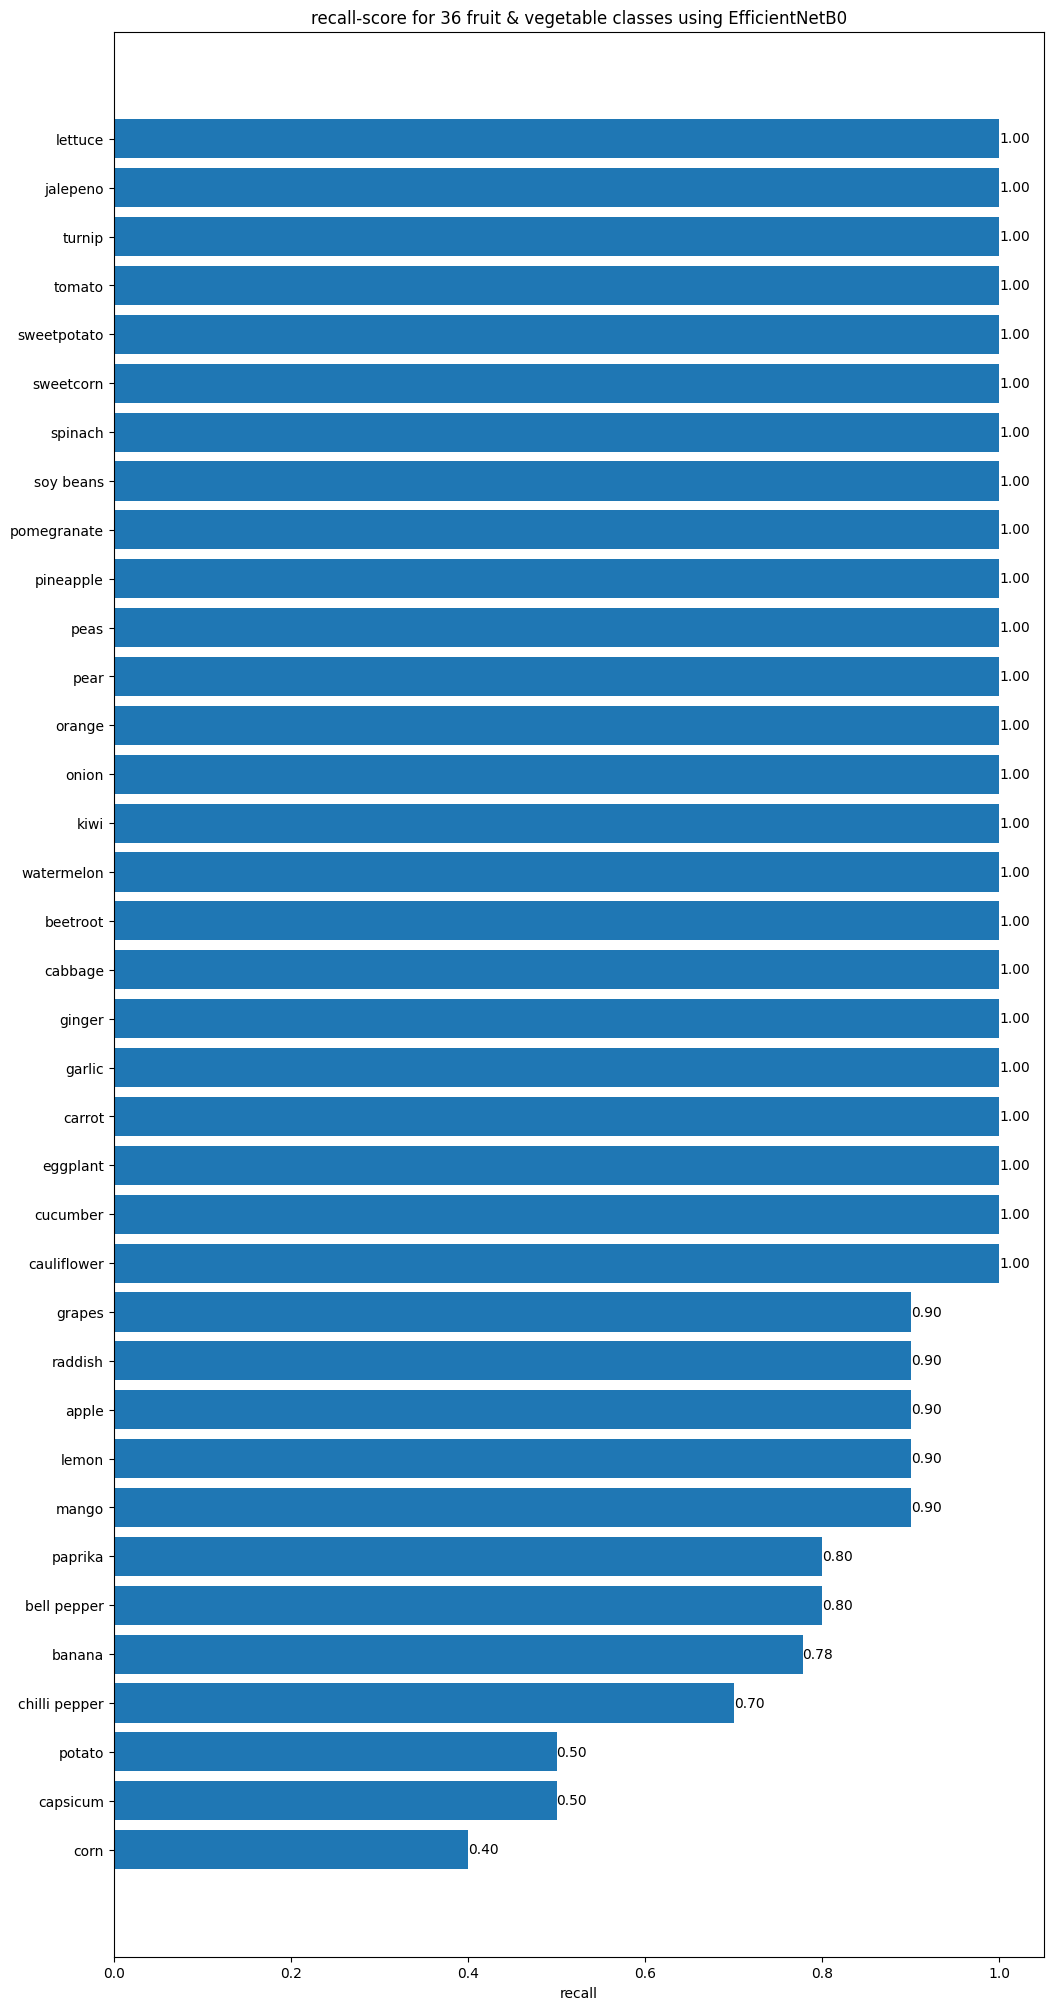

In [133]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(recall_scores_b0)), recall_scores_b0["recall"].values)
ax.set_yticks(range(len(recall_scores_b0)))
ax.set_yticklabels(recall_scores_b0["class_names"])
ax.set_xlabel("recall")
ax.set_title("recall-score for 36 fruit & vegetable classes using EfficientNetB0")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

In [134]:
class_f1_scores_b0 = {}

for k, v in classification_report_dict_b0.items():
    if k == "accuracy": 
        break
    else:
        class_f1_scores_b0[class_names[int(k)]] = v["f1-score"]
class_f1_scores_b0

{'apple': 0.8181818181818182,
 'banana': 0.8750000000000001,
 'beetroot': 0.9523809523809523,
 'bell pepper': 0.6153846153846154,
 'cabbage': 1.0,
 'capsicum': 0.5555555555555556,
 'carrot': 1.0,
 'cauliflower': 1.0,
 'chilli pepper': 0.7368421052631577,
 'corn': 0.5714285714285715,
 'cucumber': 1.0,
 'eggplant': 1.0,
 'garlic': 1.0,
 'ginger': 1.0,
 'grapes': 0.9473684210526316,
 'jalepeno': 0.9523809523809523,
 'kiwi': 1.0,
 'lemon': 0.9473684210526316,
 'lettuce': 1.0,
 'mango': 0.8181818181818182,
 'onion': 1.0,
 'orange': 0.9523809523809523,
 'paprika': 0.888888888888889,
 'pear': 0.9090909090909091,
 'peas': 1.0,
 'pineapple': 1.0,
 'pomegranate': 1.0,
 'potato': 0.6666666666666666,
 'raddish': 0.9473684210526316,
 'soy beans': 1.0,
 'spinach': 1.0,
 'sweetcorn': 0.7692307692307693,
 'sweetpotato': 1.0,
 'tomato': 1.0,
 'turnip': 1.0,
 'watermelon': 1.0}

In [135]:
import pandas as pd

f1_scores_b0 = pd.DataFrame({"class_names": list(class_f1_scores_b0.keys()),
                         "f1-score": list(class_f1_scores_b0.values())}).sort_values("f1-score", ascending=False)

In [136]:
f1_scores_b0[:10]

class_names  f1-score
18      lettuce       1.0
13       ginger       1.0
34       turnip       1.0
33       tomato       1.0
32  sweetpotato       1.0
30      spinach       1.0
29    soy beans       1.0
26  pomegranate       1.0
25    pineapple       1.0
24         peas       1.0

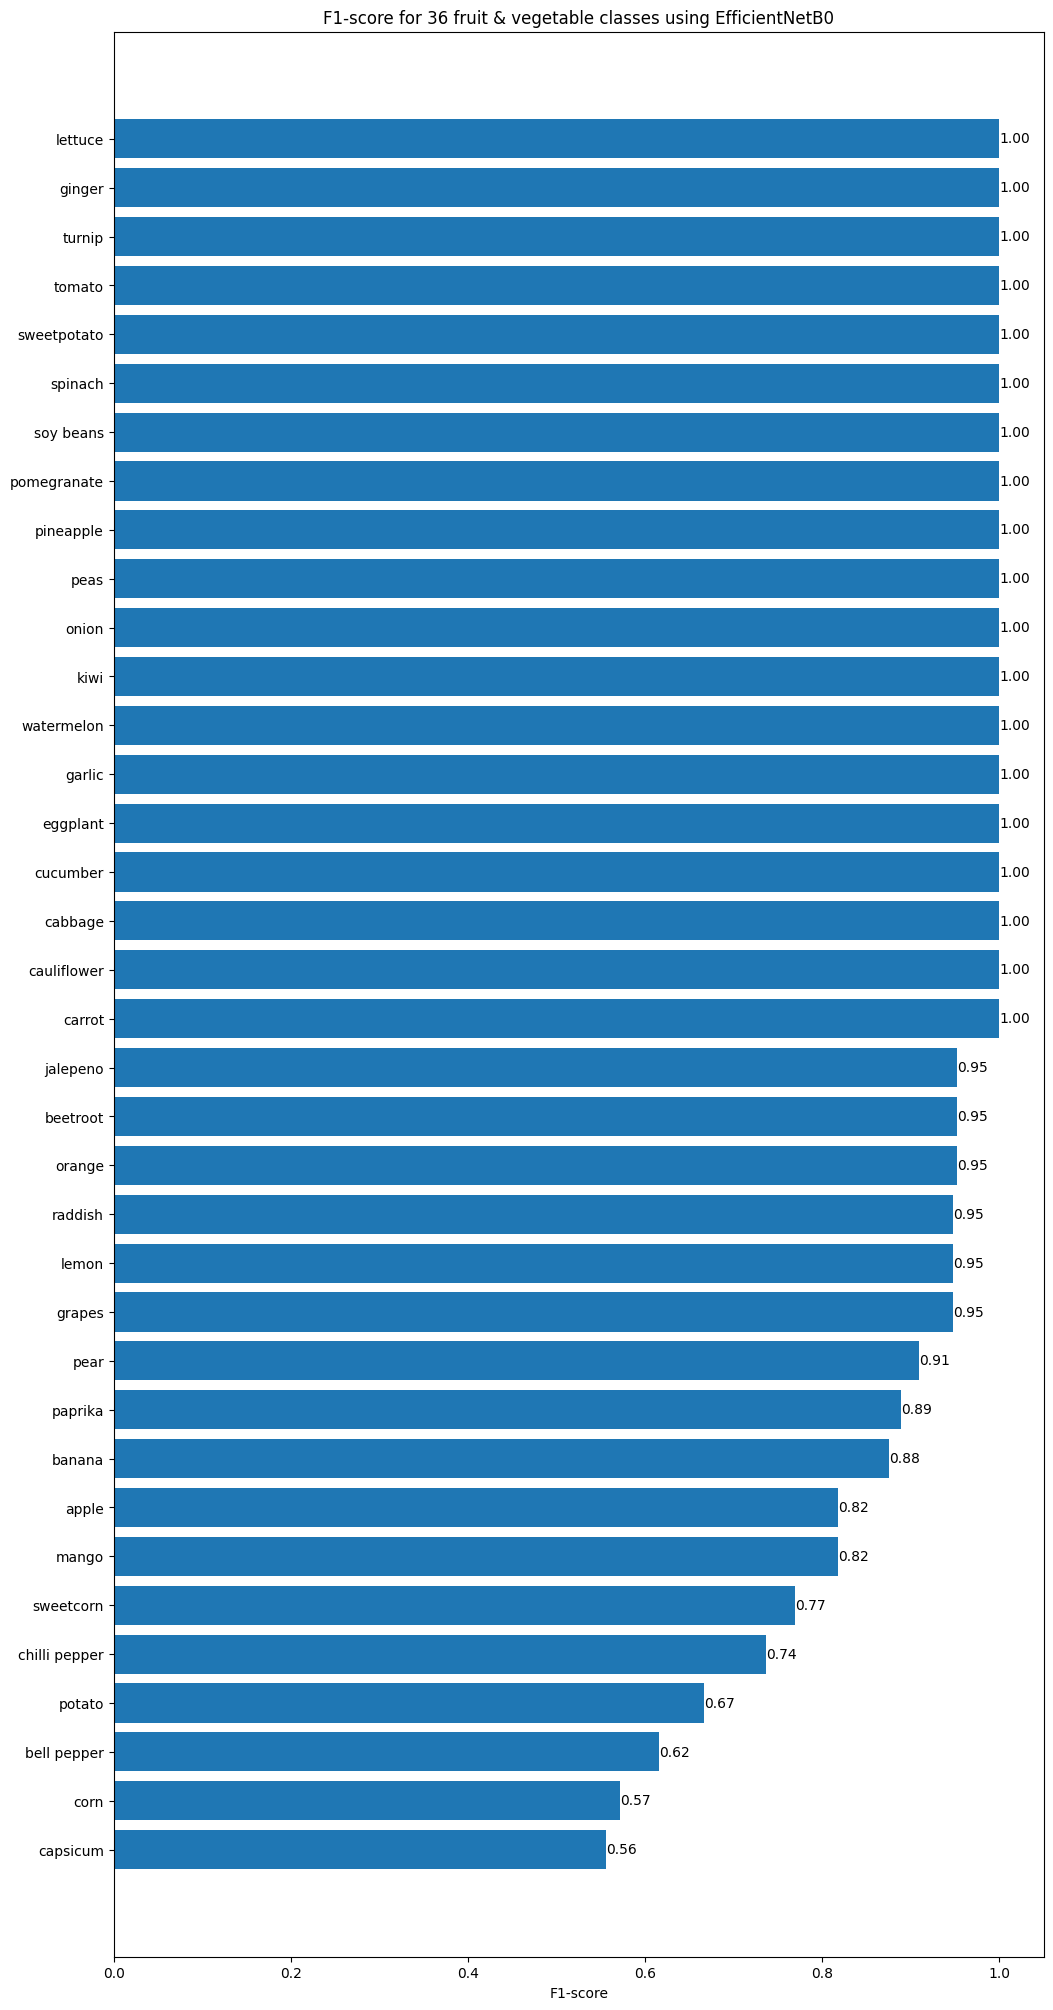

In [137]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores_b0)), f1_scores_b0["f1-score"].values)
ax.set_yticks(range(len(f1_scores_b0)))
ax.set_yticklabels(f1_scores_b0["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 36 fruit & vegetable classes using EfficientNetB0")
ax.bar_label(scores, fmt="%.2f")
ax.invert_yaxis();

#### Visualizing predictions on test images

1/1 [==============================] - 0s 28ms/step


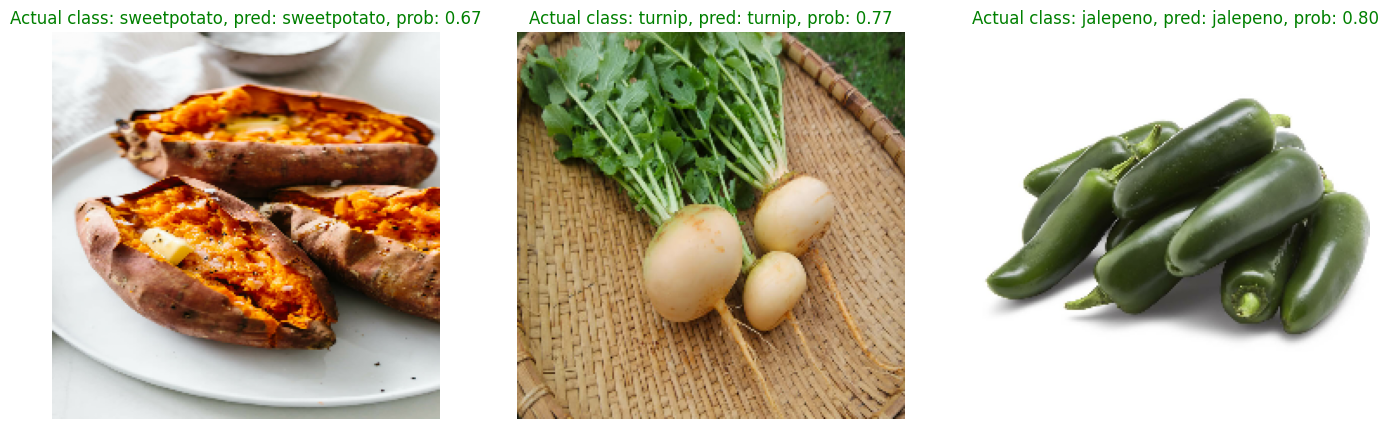

In [138]:
plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename
    
    # Load the images and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model_b0.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()] 
    
    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual class: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);
    

## Summary

We checked the accuracy of different EfficientNet Versions varying from B0 to B7 
which gave the accuracy of 0.90, 0.88, 0.88, 0.89, 0.87, 0.90, 0.87, 0.88 accordingly. 
As per our conclusion EfficientNetB5 gave the best accuracy.



## Reference: 
https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142

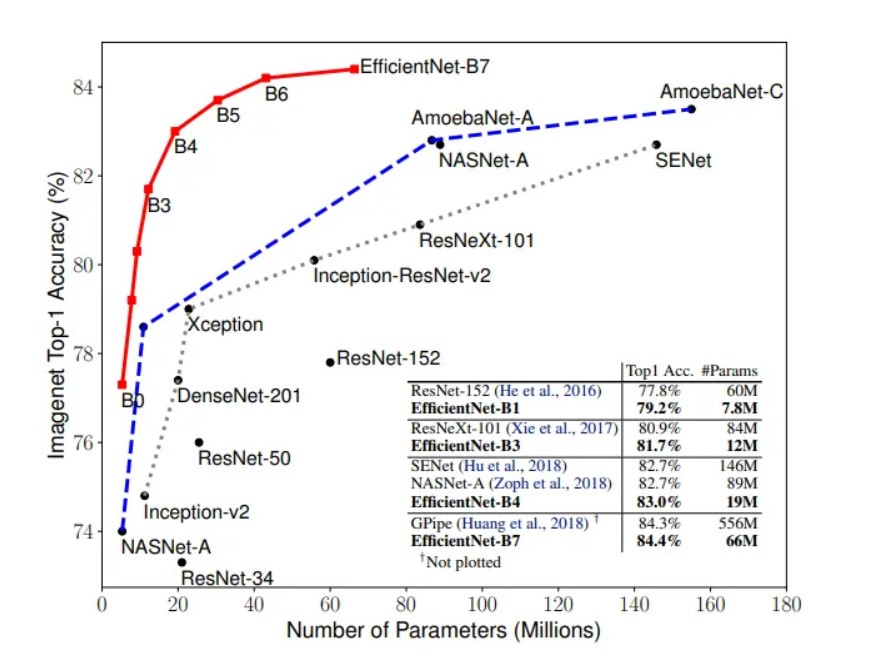

In [1]:
from IPython.display import Image
Image(filename='ModelVSAccuracy.jpg') 

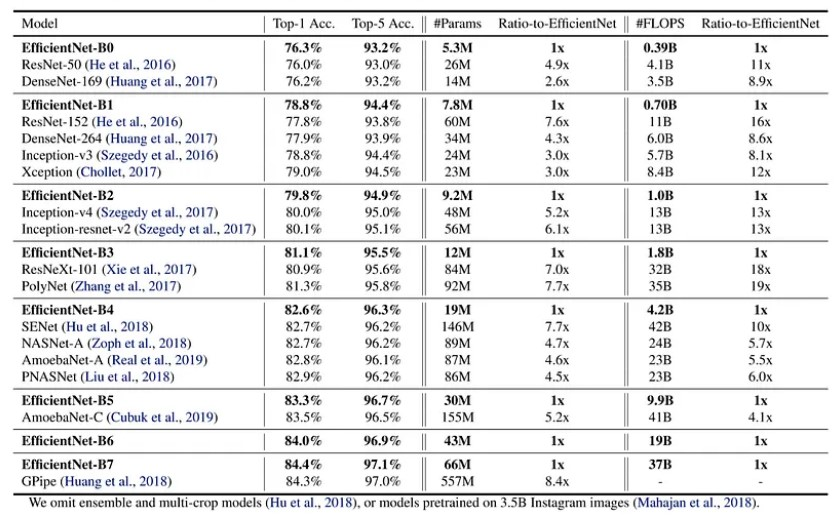

In [2]:
Image(filename='performance_result.jpg') 

### The above image shows that Efficiency increases going from B0 to B7, although it was not observed with our dataset.